In [48]:
import numpy as np
import pandas as pd
import os
import sqlite3 as sql
import requests
from bs4 import BeautifulSoup
import statsmodels.formula.api as statapi
import matplotlib as mpl 
import matplotlib.pyplot as plt
import csv
from sklearn.linear_model import LinearRegression as linreg
import seaborn as sb
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as sm
import sklearn
import statsmodels.api
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree

In [49]:
# All of the data from https://www.kaggle.com/datasets/datasnaek/chess?resource=download
entire_dataset = pd.read_csv("./games.csv")
# Pulled the headers from the CSV file
# dataset_headers raentire_dataset.columns
print(entire_dataset.columns)


Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')


In [50]:
print(entire_dataset.size)

320928


In [51]:
#games we're taking out: where either queen doesn't move, first queen move is pawn promotion
black_queen_moved = False
white_queen_moved = False
pawn_promotion_before_queen_move = False
pawn_promotion_games = []
cleaned_dataset = entire_dataset.copy()
for i, row in cleaned_dataset.iterrows():
    black_queen_moved = False
    white_queen_moved = False
    pawn_promotion_before_queen_move = False
    moves = row[12].split()
    for j, move in enumerate(moves):
        if j % 2 == 0: # even is white
            if move[0] == 'Q':
                white_queen_moved = True 
            if white_queen_moved == False and black_queen_moved == False and '=Q' in move:
                pawn_promotion_before_queen_move = True
                pawn_promotion_games.append(row[12])
        else: # odd is black
            if move[0] == 'Q':
                black_queen_moved = True 
    if(black_queen_moved == False or white_queen_moved == False or pawn_promotion_before_queen_move == True):
        cleaned_dataset = cleaned_dataset.drop(i)
print(entire_dataset.shape[0])
print(cleaned_dataset.shape[0])
# print(pawn_promotion_games)

20058
15686


In [52]:
#Only games that were rated, not "casual"
rated_dataset = entire_dataset[entire_dataset["rated"] == True]


In [53]:
# print(len(rated_dataset))
display(rated_dataset.head())

id  rated    created_at  last_move_at  turns victory_status winner  \
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   
6  qwU9rasv   True  1.504230e+12  1.504230e+12     33         resign  white   

  increment_code       white_id  white_rating            black_id  \
1           5+10           a-00          1322           skinnerua   
2           5+10         ischia          1496                a-00   
3           20+0  daniamurashov          1439        adivanov2009   
4           30+3      nik221107          1523        adivanov2009   
6           10+0        capa_jr          1520  daniel_likes_chess   

   black_rating                                              moves  \
1          1261  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...   
2          1500  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...   
3          1454  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...   
4          1469  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...   
6          1423  d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...   

  opening_eco                                opening_name  opening_ply  
1         B00      Nimzowitsch Defense: Kennedy Variation            4  
2         C20       King's Pawn Game: Leonardis Variation            3  
3         D02      Queen's Pawn Game: Zukertort Variation            3  
4         C41                            Philidor Defense            5  
6         D00  Blackmar-Diemer Gambit: Pietrowsky Defense           10

In [65]:
#This code block sums up the number of wins for each white, black, and tie and compiles a dictionary for all of the openings
#         num wins for black | num wins for white | num ties
# opening1
# opening2
# opening3
openings = {}
# opening_freq = {}
for i, row in rated_dataset.iterrows():
    opening_name = row[14]
    opening_eco = row[13]
    winner = row[6]
    openings.setdefault(opening_name, (opening_eco, [0, 0, 0, 0]))  # white, black, tie, freq (white+black+tie=freq)
    
    if winner == 'white':
        openings[opening_name][1][0] += 1
    elif winner == 'black':
        openings[opening_name][1][1] += 1
    elif winner == 'draw':
        openings[opening_name][1][2] += 1
    openings[opening_name][1][3] += 1

# openings = sorted(openings.keys())
display(openings)

{'Nimzowitsch Defense: Kennedy Variation': ('B00', [1, 2, 0, 3]),
 "King's Pawn Game: Leonardis Variation": ('C20', [54, 53, 2, 109]),
 "Queen's Pawn Game: Zukertort Variation": ('D02', [47, 32, 5, 84]),
 'Philidor Defense': ('C41', [68, 35, 6, 109]),
 'Blackmar-Diemer Gambit: Pietrowsky Defense': ('D00', [2, 0, 0, 2]),
 'Italian Game: Schilling-Kostic Gambit': ('C50', [11, 20, 3, 34]),
 'Scandinavian Defense: Mieses-Kotroc Variation': ('B01', [129, 73, 5, 207]),
 "English Opening: King's English Variation |  Reversed Closed Sicilian": ('A25',
  [13, 4, 0, 17]),
 'Sicilian Defense: Smith-Morra Gambit #2': ('B21', [45, 42, 5, 92]),
 "Queen's Pawn Game: Chigorin Variation": ('D01', [84, 91, 5, 180]),
 'Scotch Game: Haxo Gambit': ('C45', [8, 1, 0, 9]),
 'Slav Defense': ('D10', [13, 17, 3, 33]),
 "Queen's Gambit Refused: Marshall Defense": ('D06', [75, 28, 1, 104]),
 'Sicilian Defense: Canal Attack |  Main Line': ('B52', [10, 15, 0, 25]),
 'Sicilian Defense': ('B27', [125, 150, 8, 283]),
 

In [128]:
eco_win_pct = {}
for i, row in rated_dataset.iterrows():
    opening_name = row[14]
    opening_eco = row[13]
    winner = row[6]
    eco_win_pct.setdefault(opening_eco, [0, 0, 0, 0])  # white, black, tie, freq (white+black+tie=freq)
    
    if winner == 'white':
        eco_win_pct[opening_eco][0] += 1
    elif winner == 'black':
        eco_win_pct[opening_eco][1] += 1
    elif winner == 'draw':
        eco_win_pct[opening_eco][2] += 1
    eco_win_pct[opening_eco][3] += 1

# openings = sorted(openings.keys())


In [129]:
def sort_top_n_eco(num, d):
    return sorted(d.items(), key=lambda x:x[1][3], reverse=True)[0:num]

In [136]:
# Make df for eco win_pct
top_n_eco = sort_top_n_eco(50, eco_win_pct)

eco_df = pd.DataFrame(columns=['Opening_ECO', 'White_Wins', 'Black_Wins', 'Draws', 'Frequency'])

for i, eco in enumerate(top_n_eco):
    e, data = eco
    white, black, tie, freq = data
    eco_df.loc[i] = [eco[0], white, black, tie, freq]

display(eco_df.head())

Opening_ECO  White_Wins  Black_Wins  Draws  Frequency
0         A00         320         454     27        801
1         C00         365         331     31        727
2         D00         273         293     31        597
3         B01         291         272     24        587
4         C41         323         220     20        563

/var/folders/2d/xt2cq0c959507rqvlgx4fn_m0000gn/T/ipykernel_24162/3888852831.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_w.set_xticklabels(eco_df['Opening_ECO'], rotation=90)


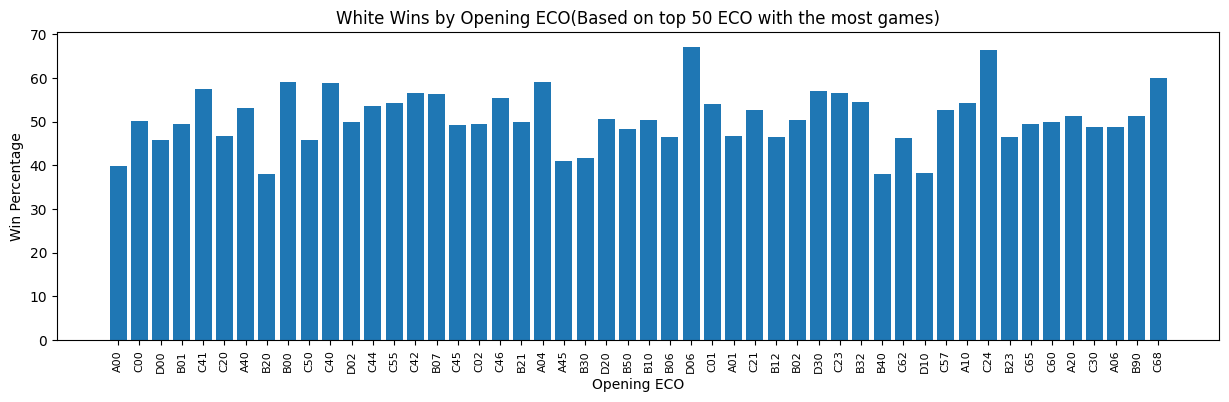

In [139]:
# make histogram for white win percentage for eco
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
white_win_percentage = 100*(eco_df['White_Wins'].astype(float)/eco_df['Frequency'].astype(float))
ax_w.bar(eco_df['Opening_ECO'], white_win_percentage)
# Set labels and title
ax_w.set_xticklabels(eco_df['Opening_ECO'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# ax_w.tick_params(axis='x', which='major', pad=.5)
ax_w.set_xlabel('Opening ECO')
ax_w.set_ylabel('Win Percentage')
ax_w.set_title('White Wins by Opening ECO(Based on top 50 ECO with the most games)')
plt.show()

/var/folders/2d/xt2cq0c959507rqvlgx4fn_m0000gn/T/ipykernel_24162/3748568879.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_w.set_xticklabels(eco_df['Opening_ECO'], rotation=90)


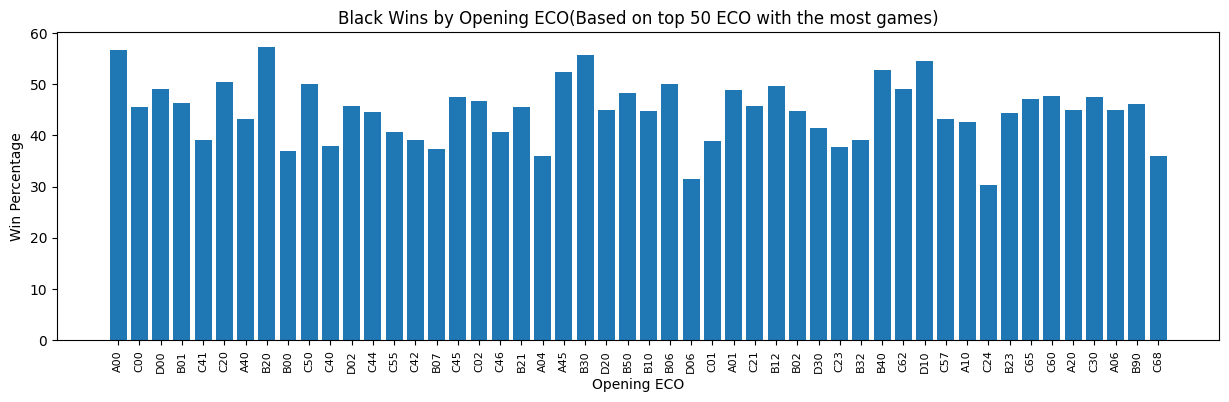

In [146]:
# make histogram for black win percentage for eco
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
black_win_percentage = 100*(eco_df['Black_Wins'].astype(float)/eco_df['Frequency'].astype(float))
ax_w.bar(eco_df['Opening_ECO'], black_win_percentage)
# Set labels and title
ax_w.set_xticklabels(eco_df['Opening_ECO'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# ax_w.tick_params(axis='x', which='major', pad=.5)
ax_w.set_xlabel('Opening ECO')
ax_w.set_ylabel('Win Percentage')
ax_w.set_title('Black Wins by Opening ECO(Based on top 50 ECO with the most games)')
plt.show()

/var/folders/2d/xt2cq0c959507rqvlgx4fn_m0000gn/T/ipykernel_24162/3749139374.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_d.set_xticklabels(eco_df['Opening_ECO'], rotation=90)


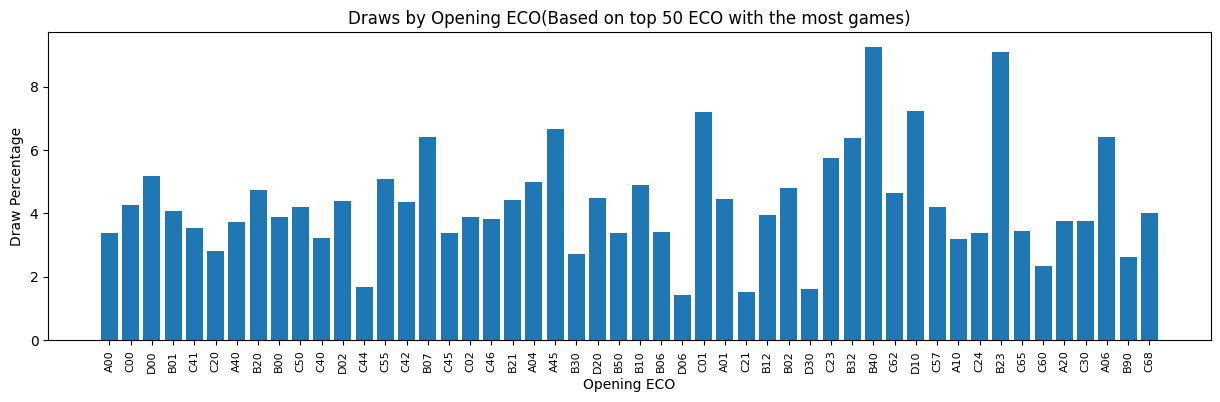

In [145]:
# make histogram for white win percentage for eco
fig_d, ax_d = plt.subplots(figsize=(15, 4))

# Create a bar chart
draw_percentage = 100*(eco_df['Draws'].astype(float)/eco_df['Frequency'].astype(float))
ax_d.bar(eco_df['Opening_ECO'], draw_percentage)
# Set labels and title
ax_d.set_xticklabels(eco_df['Opening_ECO'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# ax_w.tick_params(axis='x', which='major', pad=.5)
ax_d.set_xlabel('Opening ECO')
ax_d.set_ylabel('Draw Percentage')
ax_d.set_title('Draws by Opening ECO(Based on top 50 ECO with the most games)')
plt.show()

In [55]:
def top_n(num, d):
    return sorted(d.items(), key=lambda x:x[1][1][3], reverse=True)[0:num]

In [120]:
# x values (bins) for all histograms
sorted_openings = sorted(openings)
top_n_openings = top_n(50, openings)
print(top_n_openings)
top_n_openings_df = pd.DataFrame(columns=['Opening_Name', 'Opening_ECO', 'White_Wins', 'Black_Wins', 'Draws', 'Frequency'])
for i, opening in enumerate(top_n_openings):
    eco, data = openings[opening[0]]
    white, black, tie, freq = data
    top_n_openings_df.loc[i] = [opening[0], eco, white, black, tie, freq]


x_values = [ele[0] for ele in top_n_openings]
# display(top_n_openings)


[("Van't Kruijs Opening", ('A00', [97, 198, 13, 308])), ('Sicilian Defense', ('B27', [125, 150, 8, 283])), ('Sicilian Defense: Bowdler Attack', ('B20', [97, 139, 12, 248])), ('French Defense: Knight Variation', ('C00', [116, 100, 13, 229])), ('Scotch Game', ('C44', [112, 99, 8, 219])), ('Scandinavian Defense: Mieses-Kotroc Variation', ('B01', [129, 73, 5, 207])), ("Queen's Pawn Game: Mason Attack", ('D00', [92, 86, 9, 187])), ('Scandinavian Defense', ('B01', [80, 96, 10, 186])), ('Horwitz Defense', ('A40', [96, 83, 5, 184])), ("Queen's Pawn Game: Chigorin Variation", ('D01', [84, 91, 5, 180])), ('Caro-Kann Defense', ('B10', [95, 74, 6, 175])), ('Philidor Defense #2', ('C41', [81, 79, 7, 167])), ('Italian Game: Anti-Fried Liver Defense', ('C55', [83, 60, 8, 151])), ('Philidor Defense #3', ('C41', [98, 50, 3, 151])), ('Sicilian Defense: Old Sicilian', ('B30', [51, 83, 5, 139])), ('Modern Defense', ('A40', [63, 71, 4, 138])), ('Indian Game', ('A45', [51, 77, 10, 138])), ("King's Pawn Game

/var/folders/2d/xt2cq0c959507rqvlgx4fn_m0000gn/T/ipykernel_24162/1587144402.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_w.set_xticklabels(top_n_openings_df['Opening_Name'], rotation=90)


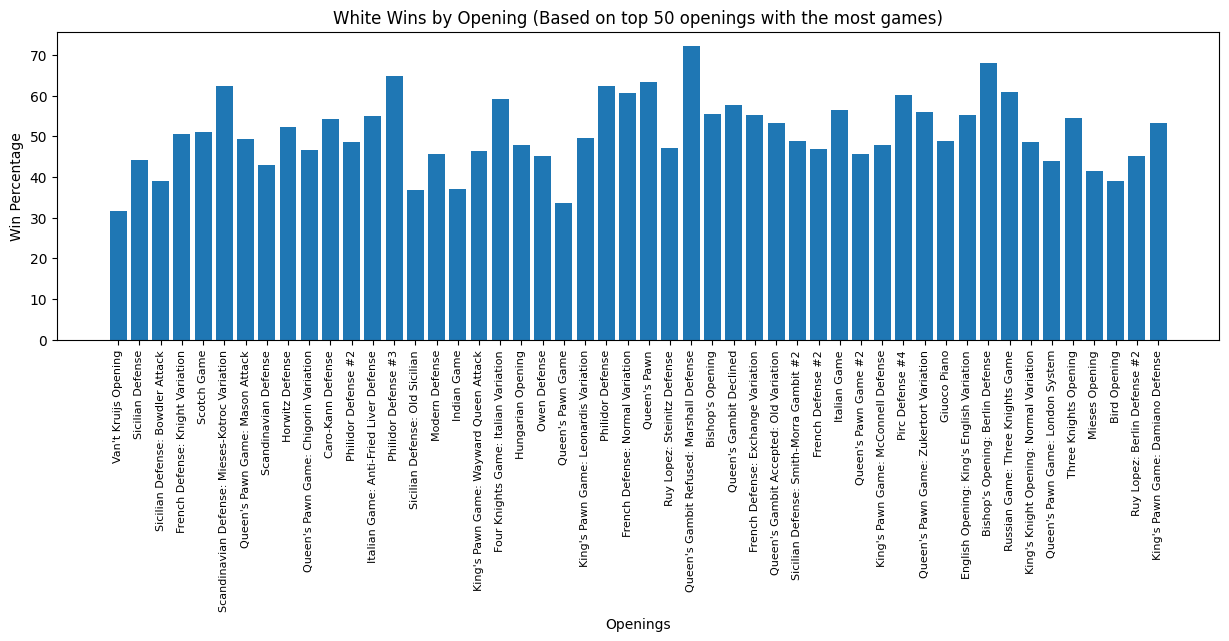

In [135]:
# make histogram for white win percentage
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
white_win_percentage = 100*(top_n_openings_df['White_Wins'].astype(float)/top_n_openings_df['Frequency'].astype(float))
ax_w.bar(top_n_openings_df['Opening_Name'], white_win_percentage)
# Set labels and title
ax_w.set_xticklabels(top_n_openings_df['Opening_Name'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# ax_w.tick_params(axis='x', which='major', pad=.5)
ax_w.set_xlabel('Openings')
ax_w.set_ylabel('Win Percentage')
ax_w.set_title('White Wins by Opening (Based on top 50 openings with the most games)')
plt.show()

# for i, row in top_n_openings_df.iterrows():
#     name = row[0]
#     eco = row[1]
#     print(f'{i+1})', eco, '-->', name)

/var/folders/2d/xt2cq0c959507rqvlgx4fn_m0000gn/T/ipykernel_24162/550972689.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_w.set_xticklabels(top_n_openings_df['Opening_Name'], rotation=90)


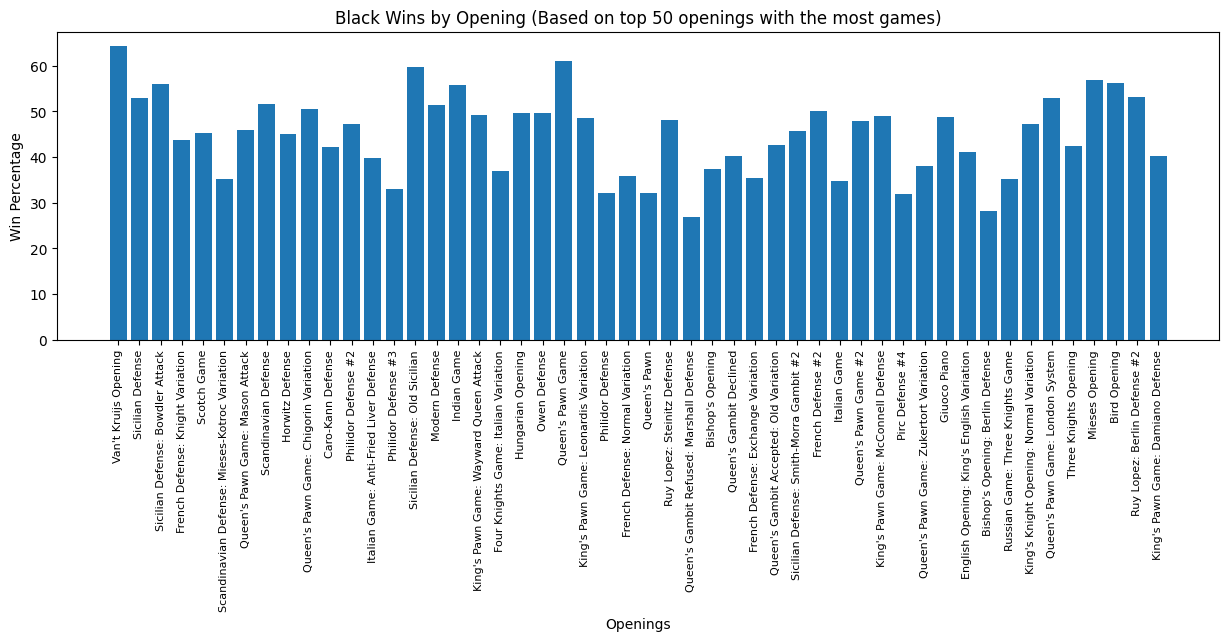

In [58]:
# make histogram for black win percentage
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
black_win_percentage = 100*(top_n_openings_df['Black_Wins'].astype(float)/top_n_openings_df['Frequency'].astype(float))
ax_w.bar(top_n_openings_df['Opening_Name'], black_win_percentage)
# Set labels and title
ax_w.set_xticklabels(top_n_openings_df['Opening_Name'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# ax_w.tick_params(axis='x', which='major', pad=.5)
ax_w.set_xlabel('Openings')
ax_w.set_ylabel('Win Percentage')
ax_w.set_title('Black Wins by Opening (Based on top 50 openings with the most games)')
plt.show()

/var/folders/2d/xt2cq0c959507rqvlgx4fn_m0000gn/T/ipykernel_24162/3360370114.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_w.set_xticklabels(top_n_openings_df['Opening_Name'], rotation=90)


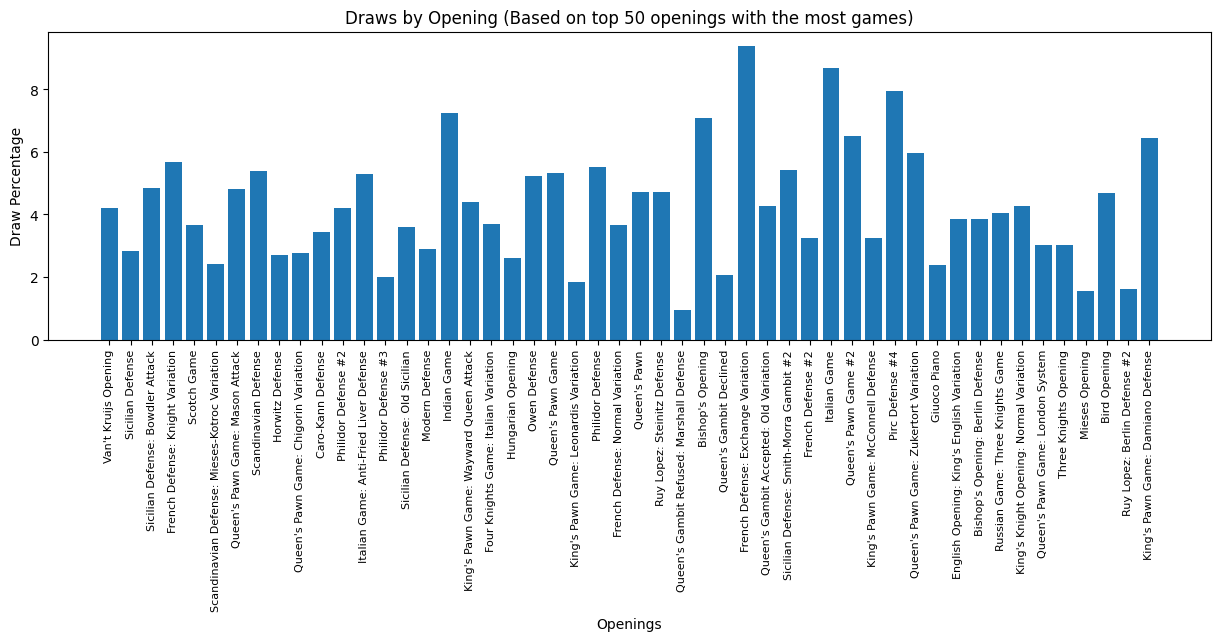

In [59]:
# make histogram for draw percentage
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
draw_percentage = 100*(top_n_openings_df['Draws'].astype(float)/top_n_openings_df['Frequency'].astype(float))
ax_w.bar(top_n_openings_df['Opening_Name'], draw_percentage)
# Set labels and title
ax_w.set_xticklabels(top_n_openings_df['Opening_Name'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# ax_w.tick_params(axis='x', which='major', pad=.5)
ax_w.set_xlabel('Openings')
ax_w.set_ylabel('Draw Percentage')
ax_w.set_title('Draws by Opening (Based on top 50 openings with the most games)')
plt.show()

# for i, row in top_n_openings_df.iterrows():
#     name = row[0]
#     eco = row[1]
#     print(f'{i+1})', eco, '-->', name)

In [60]:
print(max(rated_dataset['white_rating']))
print(max(rated_dataset['black_rating']))
print(min(rated_dataset['white_rating']))
print(min(rated_dataset['black_rating']))

# elo_opening = {"1000-1200": {"Sicilian Defense": 10, "French Defense": 5, "Caro-Kann Defense": 8}, ...}
elo_openings = {'700-900': {}, 
                '901-1100': {},
                '1101-1300': {},
                '1301-1500': {},
                '1501-1700': {},
                '1701-1900': {},
                '1901-2100': {},
                '2101-2300': {},
                '2301-2500': {},
                '2501-2700': {},
                }

for i, row in rated_dataset.iterrows():
    opening_name = row['opening_name']
    white_elo = row['white_rating']
    black_elo = row['black_rating']
    if 700 <= white_elo <= 900:
        elo_openings['700-900'].setdefault(opening_name, 0)
        elo_openings['700-900'][opening_name] += 1
    elif 901 <= white_elo <= 1100:
        elo_openings['901-1100'].setdefault(opening_name, 0)
        elo_openings['901-1100'][opening_name] += 1
    elif 1101 <= white_elo <= 1300:
        elo_openings['1101-1300'].setdefault(opening_name, 0)
        elo_openings['1101-1300'][opening_name] += 1
    elif 1301 <= white_elo <= 1500:
        elo_openings['1301-1500'].setdefault(opening_name, 0)
        elo_openings['1301-1500'][opening_name] += 1
    elif 1501 <= white_elo <= 1700:
        elo_openings['1501-1700'].setdefault(opening_name, 0)
        elo_openings['1501-1700'][opening_name] += 1     
    elif 1701 <= white_elo <= 1900:
        elo_openings['1701-1900'].setdefault(opening_name, 0)
        elo_openings['1701-1900'][opening_name] += 1
    elif 1901 <= white_elo <= 2100:
        elo_openings['1901-2100'].setdefault(opening_name, 0)
        elo_openings['1901-2100'][opening_name] += 1
    elif 2101 <= white_elo <= 2300:
        elo_openings['2101-2300'].setdefault(opening_name, 0)
        elo_openings['2101-2300'][opening_name] += 1
    elif 2301 <= white_elo <= 2500:
        elo_openings['2301-2500'].setdefault(opening_name, 0)
        elo_openings['2301-2500'][opening_name] += 1
    elif 2501 <= white_elo <= 2700:
        elo_openings['2501-2700'].setdefault(opening_name, 0)
        elo_openings['2501-2700'][opening_name] += 1
    # check black
    if 700 <= black_elo <= 900:
        elo_openings['700-900'].setdefault(opening_name, 0)
        elo_openings['700-900'][opening_name] += 1
    elif 901 <= black_elo <= 1100:
        elo_openings['901-1100'].setdefault(opening_name, 0)
        elo_openings['901-1100'][opening_name] += 1
    elif 1101 <= black_elo <= 1300:
        elo_openings['1101-1300'].setdefault(opening_name, 0)
        elo_openings['1101-1300'][opening_name] += 1
    elif 1301 <= black_elo <= 1500:
        elo_openings['1301-1500'].setdefault(opening_name, 0)
        elo_openings['1301-1500'][opening_name] += 1
    elif 1501 <= black_elo <= 1700:
        elo_openings['1501-1700'].setdefault(opening_name, 0)
        elo_openings['1501-1700'][opening_name] += 1     
    elif 1701 <= black_elo <= 1900:
        elo_openings['1701-1900'].setdefault(opening_name, 0)
        elo_openings['1701-1900'][opening_name] += 1
    elif 1901 <= black_elo <= 2100:
        elo_openings['1901-2100'].setdefault(opening_name, 0)
        elo_openings['1901-2100'][opening_name] += 1
    elif 2101 <= black_elo <= 2300:
        elo_openings['2101-2300'].setdefault(opening_name, 0)
        elo_openings['2101-2300'][opening_name] += 1
    elif 2301 <= black_elo <= 2500:
        elo_openings['2301-2500'].setdefault(opening_name, 0)
        elo_openings['2301-2500'][opening_name] += 1
    elif 2501 <= black_elo <= 2700:
        elo_openings['2501-2700'].setdefault(opening_name, 0)
        elo_openings['2501-2700'][opening_name] += 1

2622
2588
784
789


In [61]:
# sorted(d.items(), key=lambda x:x[1][1][3], reverse=True)
for elo_range, openings in elo_openings.items():
    sorted_openings = sorted(openings.items(), key=lambda x:x[1], reverse=True)
    print(f'Top 5 Openings for ELO Range {elo_range}')
    for i, (opening, freq) in enumerate(sorted_openings[:5]):
        print(f'{i + 1}. {opening}')
    print()

Top 5 Openings for ELO Range 700-900
1. Van't Kruijs Opening
2. Scandinavian Defense
3. King's Pawn Game: Leonardis Variation
4. Queen's Pawn Game
5. King's Pawn Game

Top 5 Openings for ELO Range 901-1100
1. Van't Kruijs Opening
2. Scandinavian Defense
3. Sicilian Defense
4. King's Pawn Game: Wayward Queen Attack
5. Queen's Pawn Game: Chigorin Variation

Top 5 Openings for ELO Range 1101-1300
1. Van't Kruijs Opening
2. Scandinavian Defense
3. King's Pawn Game: Wayward Queen Attack
4. Queen's Pawn Game: Chigorin Variation
5. Sicilian Defense

Top 5 Openings for ELO Range 1301-1500
1. Van't Kruijs Opening
2. Sicilian Defense
3. Scandinavian Defense: Mieses-Kotroc Variation
4. Scotch Game
5. Sicilian Defense: Bowdler Attack

Top 5 Openings for ELO Range 1501-1700
1. Sicilian Defense: Bowdler Attack
2. Scotch Game
3. Sicilian Defense
4. French Defense: Knight Variation
5. Caro-Kann Defense

Top 5 Openings for ELO Range 1701-1900
1. Sicilian Defense
2. French Defense: Knight Variation
3. S

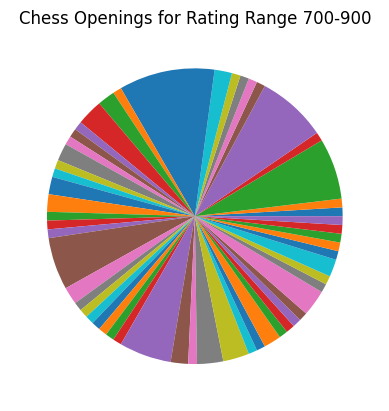

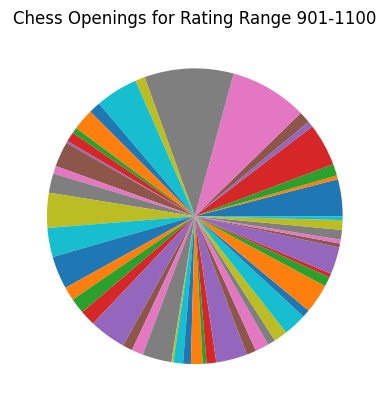

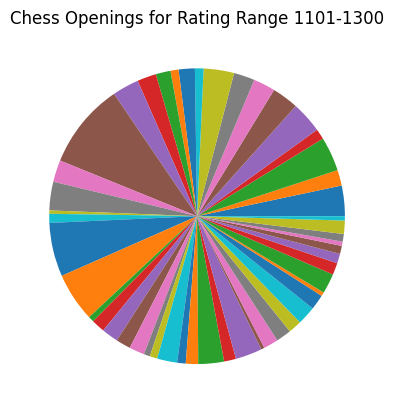

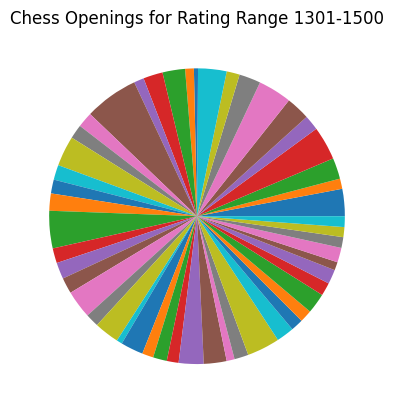

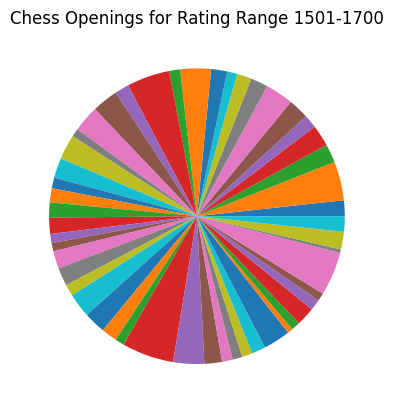

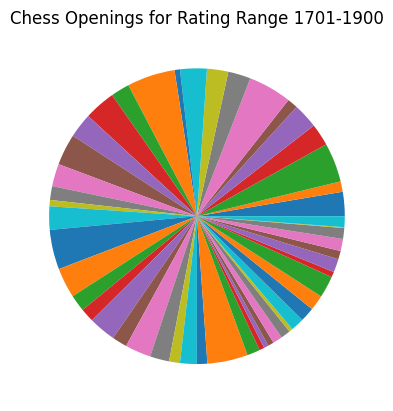

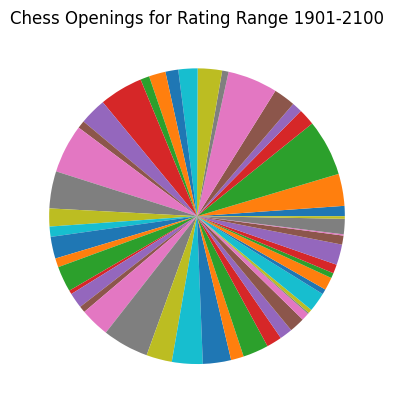

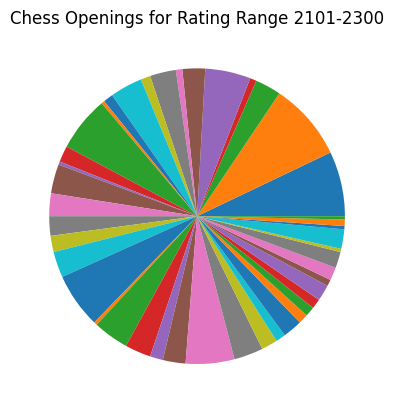

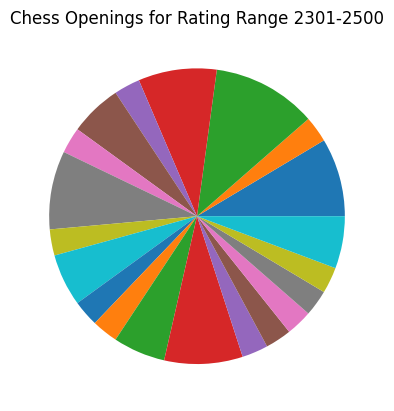

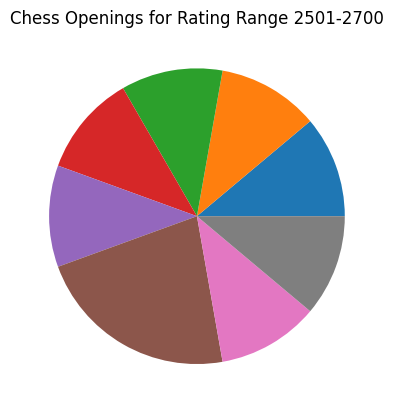

In [62]:
for rating_range, opening_freqs in elo_openings.items():
    ops = []
    frequencies = []

    # Get the openings and frequencies for this rating range
    if len(opening_freqs.keys()) > 100:
        for opening, frequency in opening_freqs.items():
            top_openings = [tup[0] for tup in top_n_openings]
            if opening in top_openings:
                ops.append(opening)
                frequencies.append(frequency)
    else:
        for opening, frequency in opening_freqs.items():
            ops.append(opening)
            frequencies.append(frequency)

    # Create a pie chart
    plt.pie(frequencies)
    plt.title("Chess Openings for Rating Range {}".format(rating_range))
    plt.show()

In [63]:
print('Italian Game' in openings.keys())

False


/var/folders/2d/xt2cq0c959507rqvlgx4fn_m0000gn/T/ipykernel_24162/4182034132.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_w.set_xticklabels(ops, rotation=90)


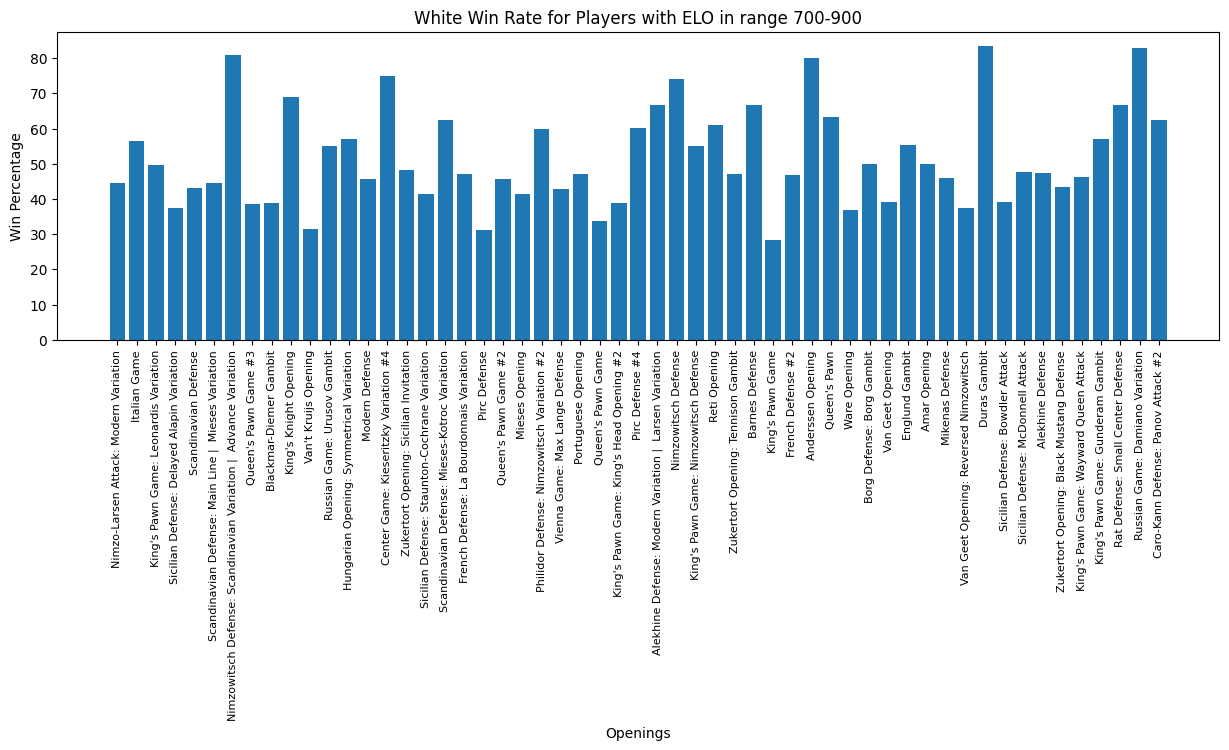

/var/folders/2d/xt2cq0c959507rqvlgx4fn_m0000gn/T/ipykernel_24162/4182034132.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_b.set_xticklabels(ops, rotation=90)


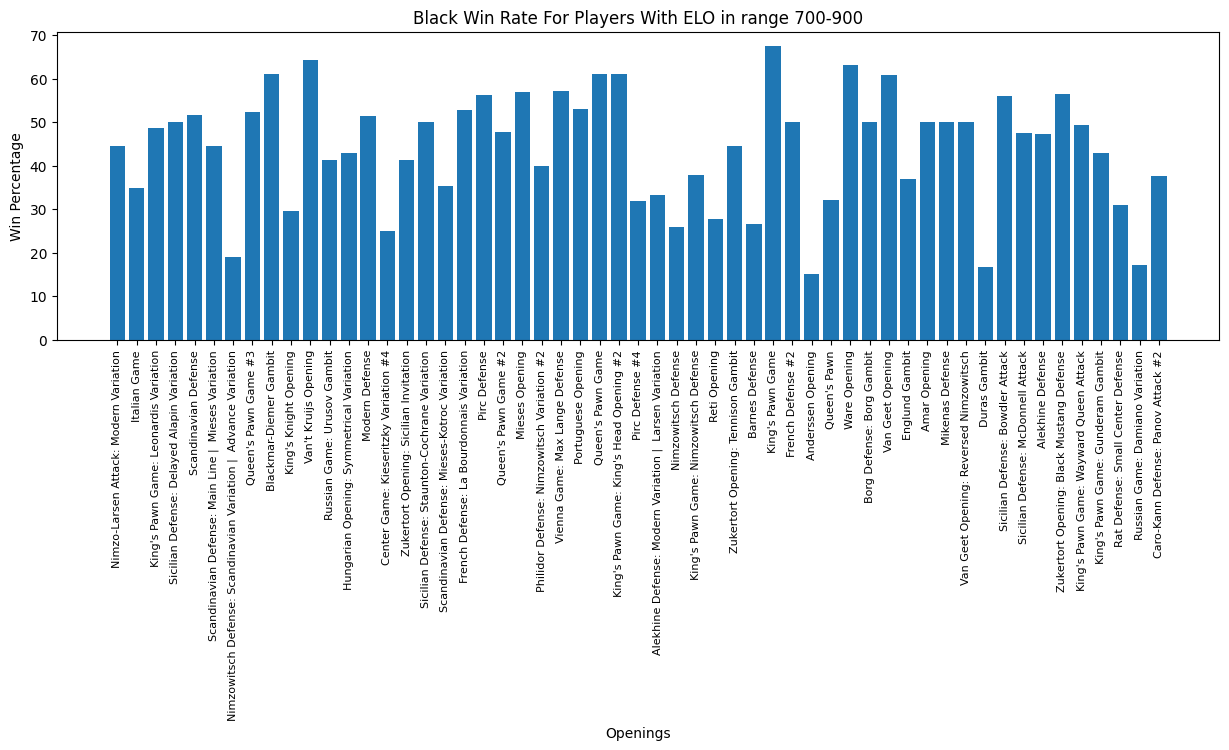

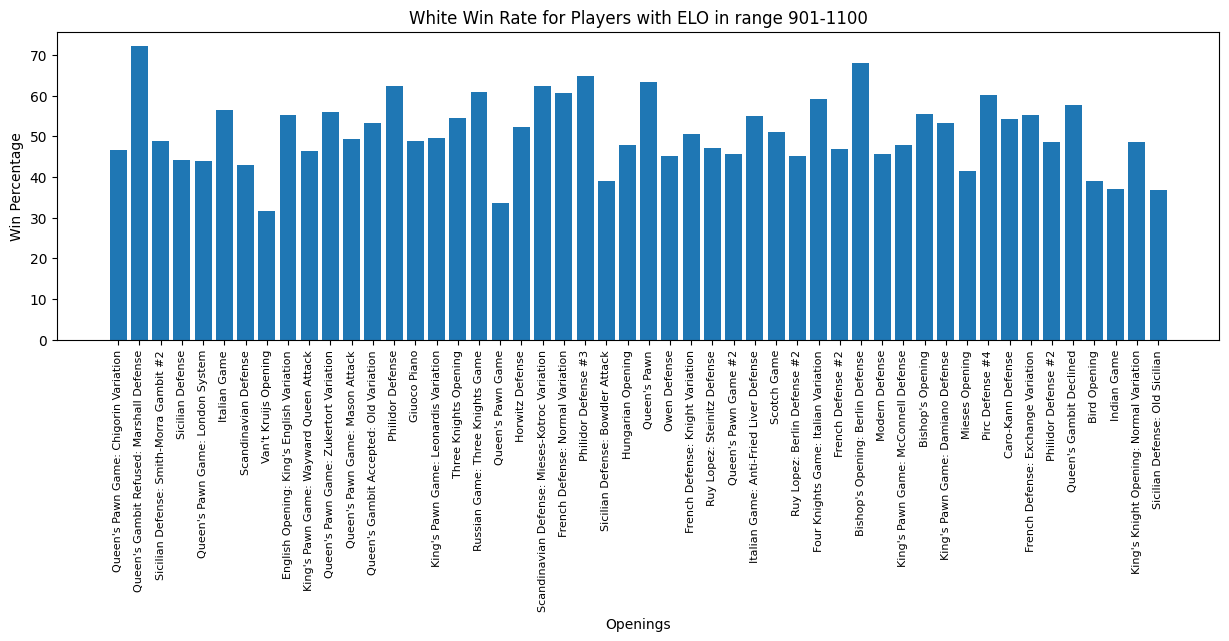

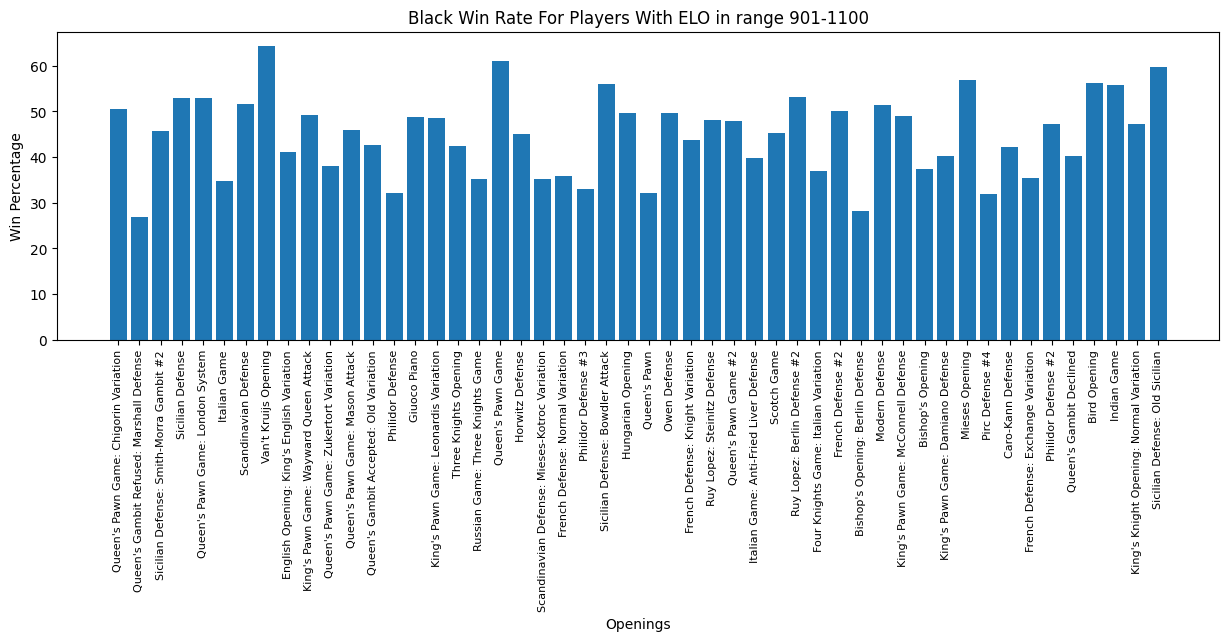

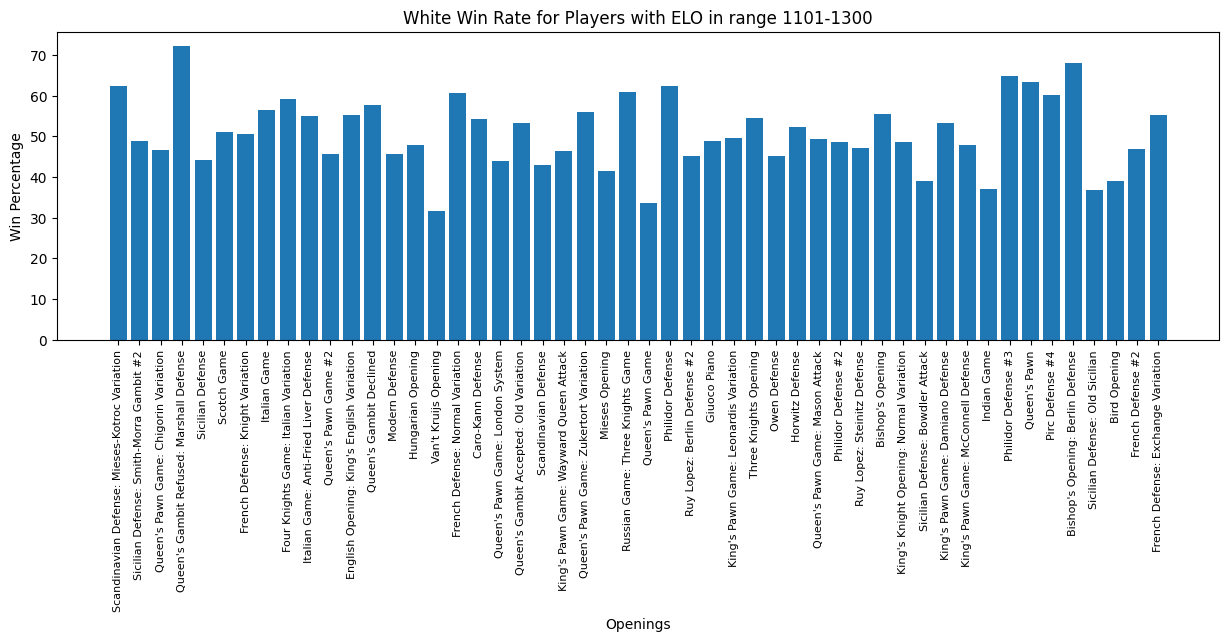

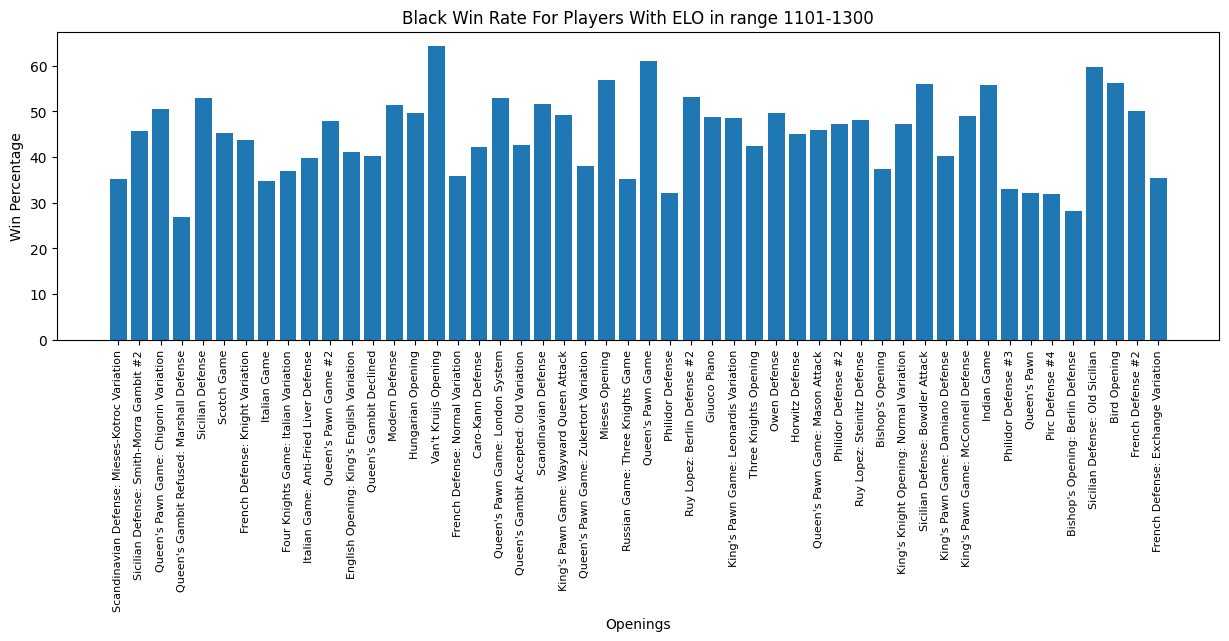

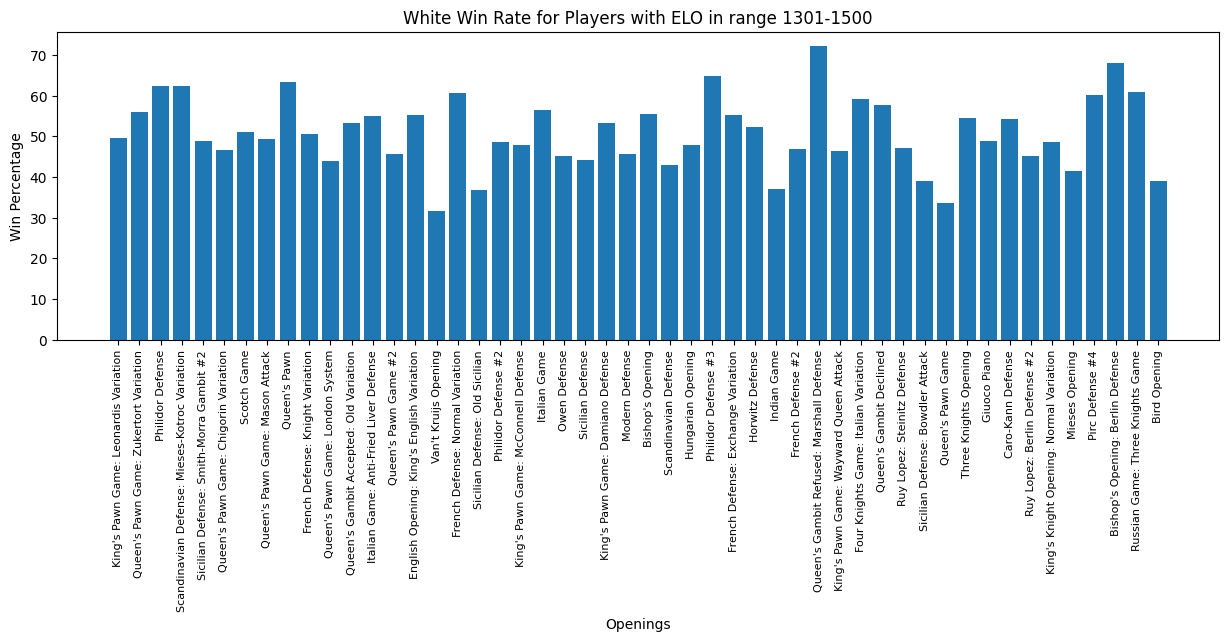

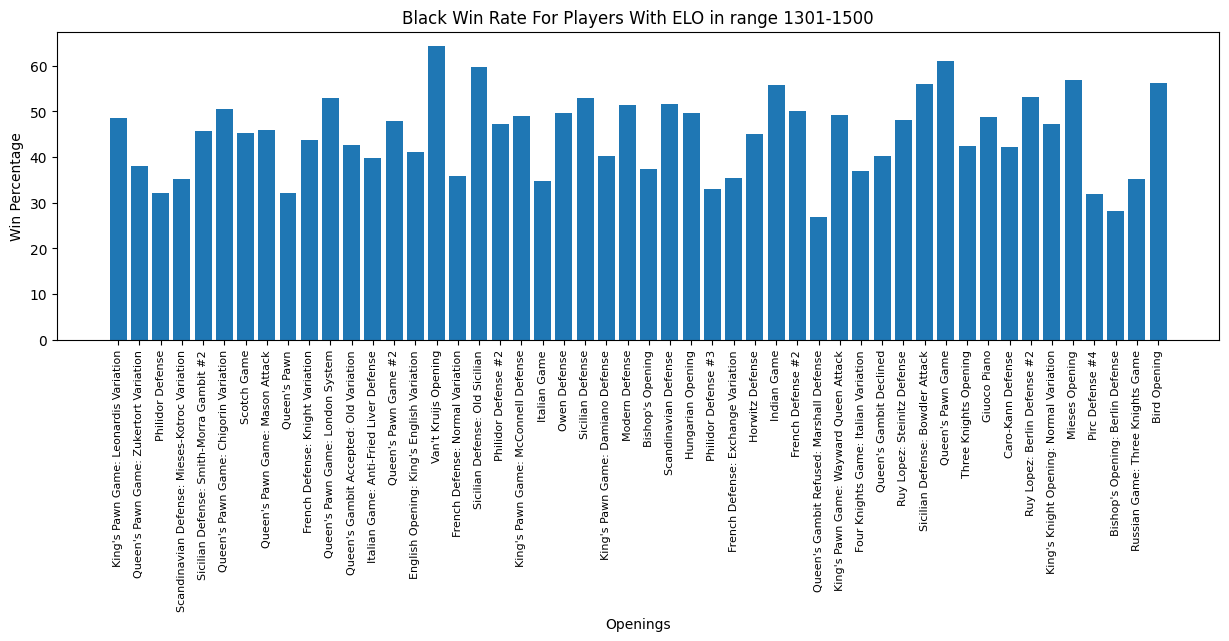

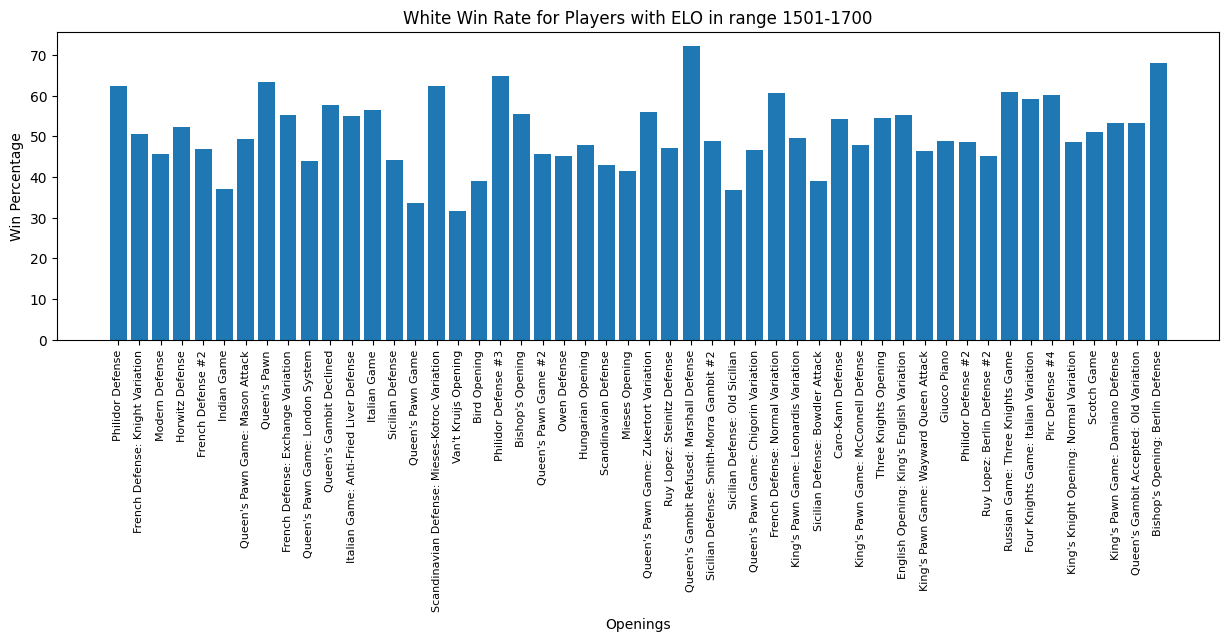

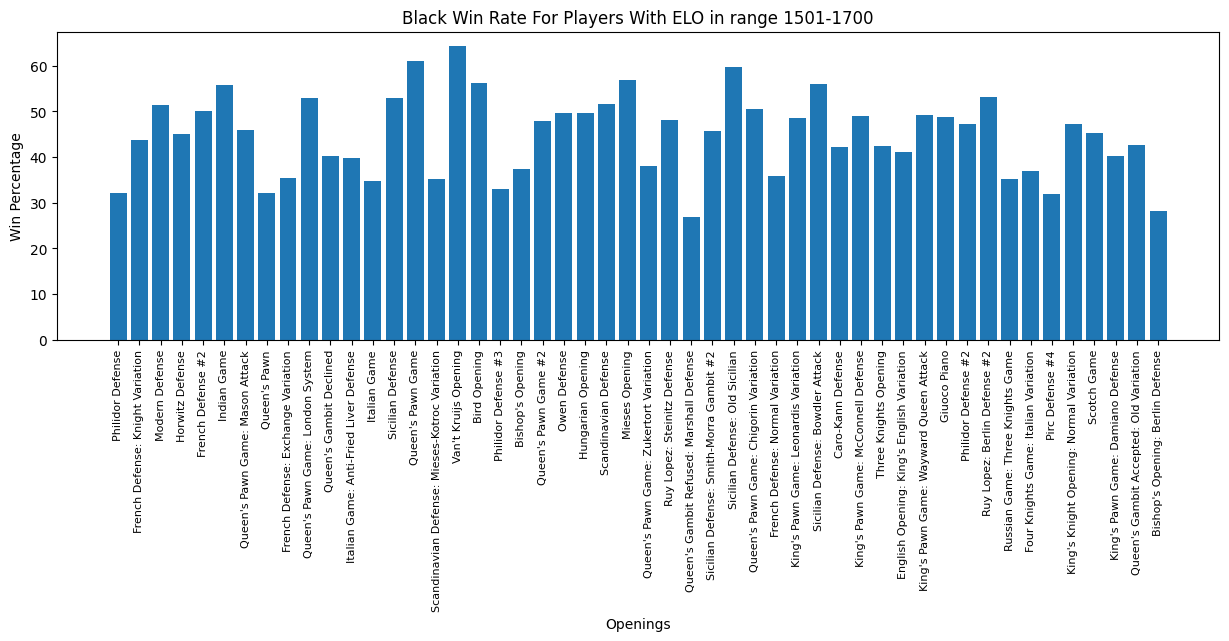

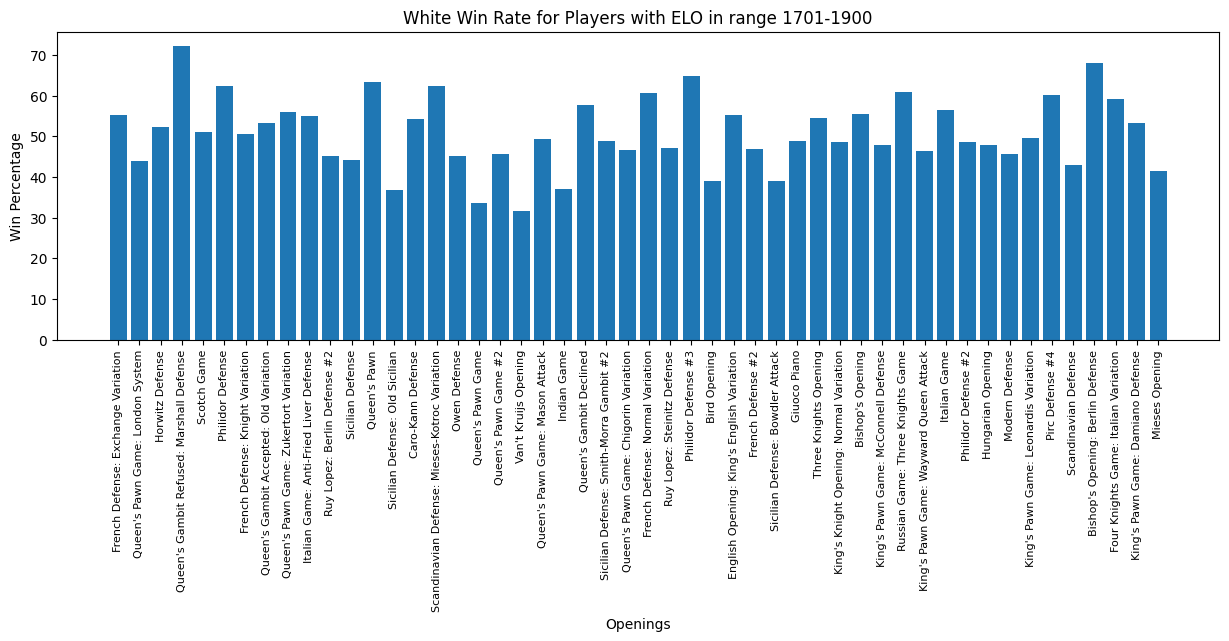

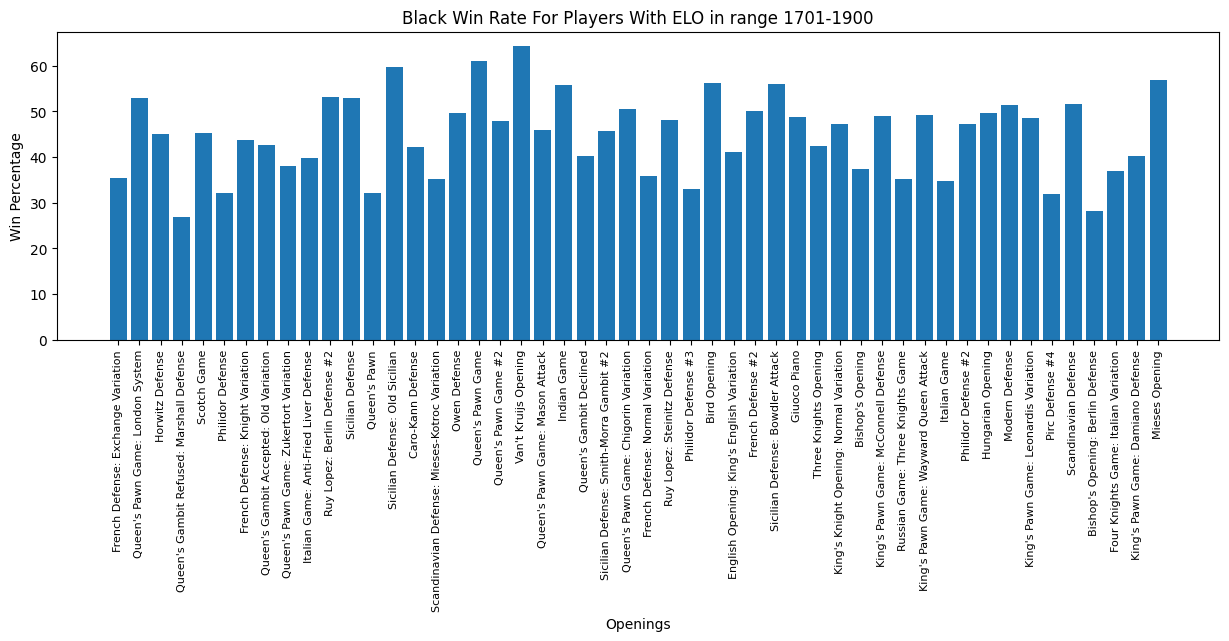

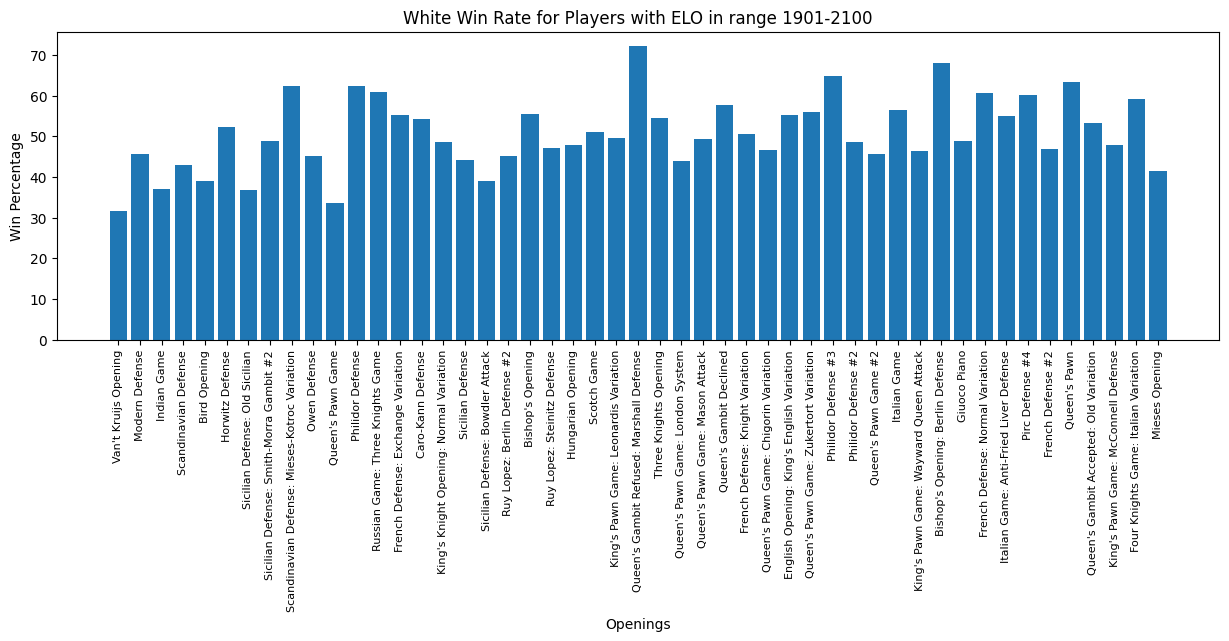

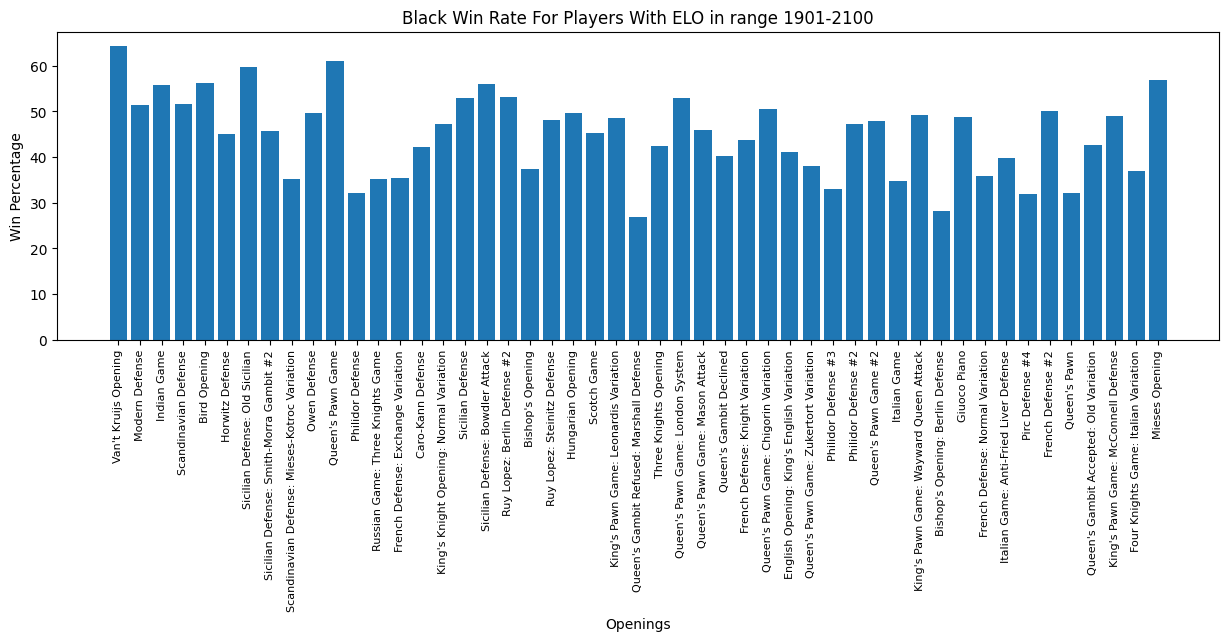

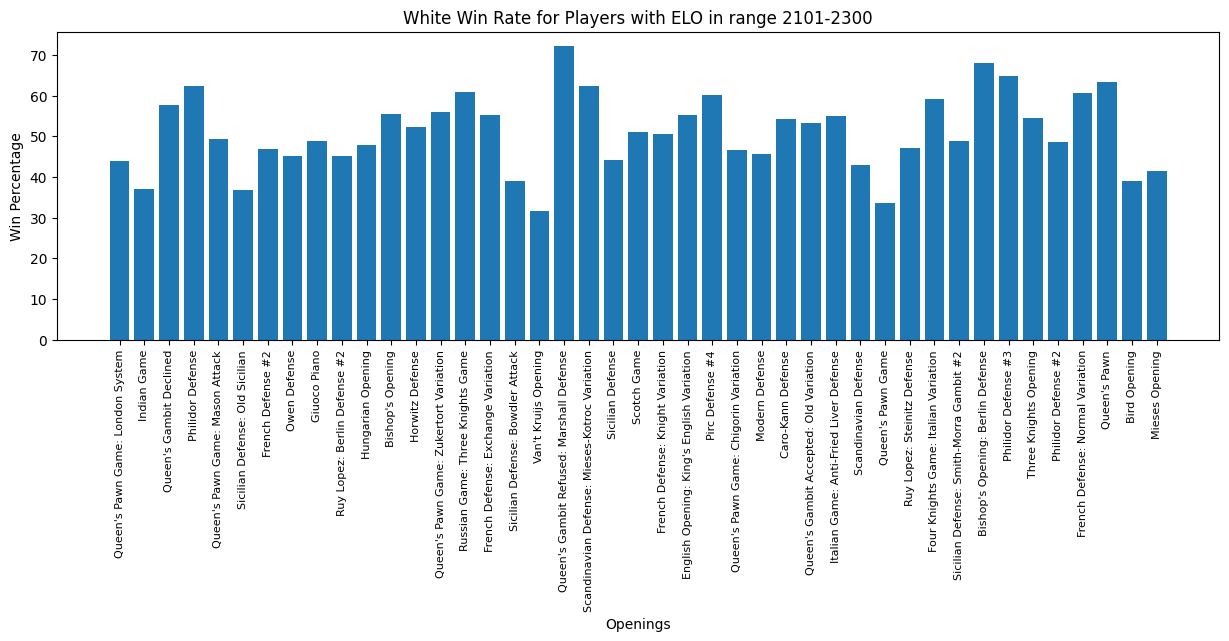

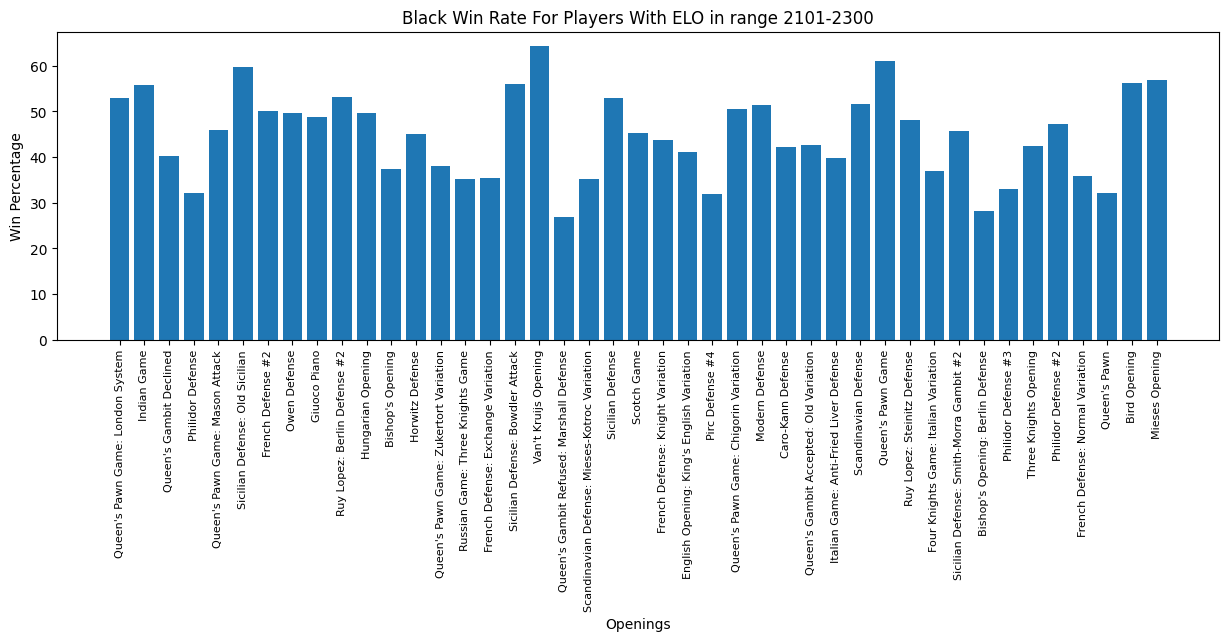

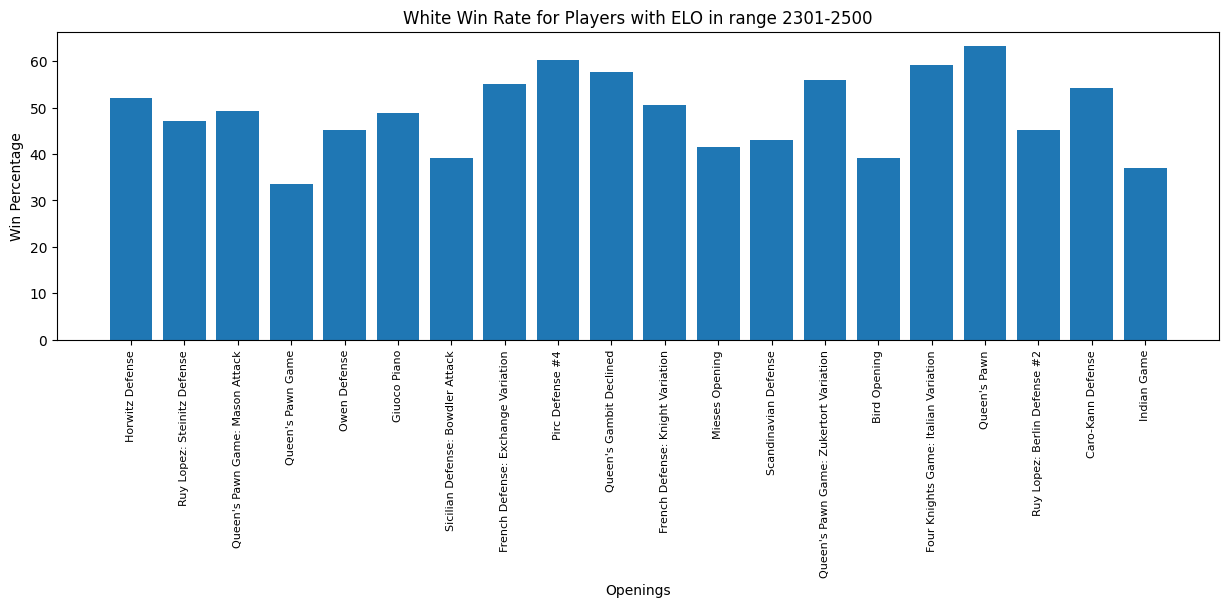

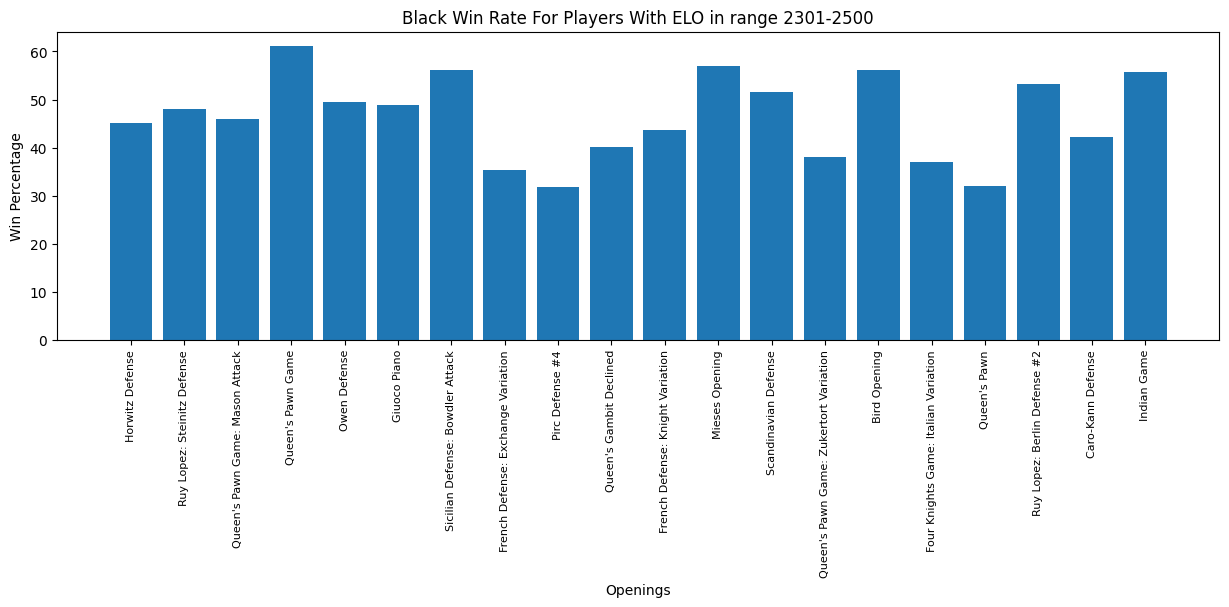

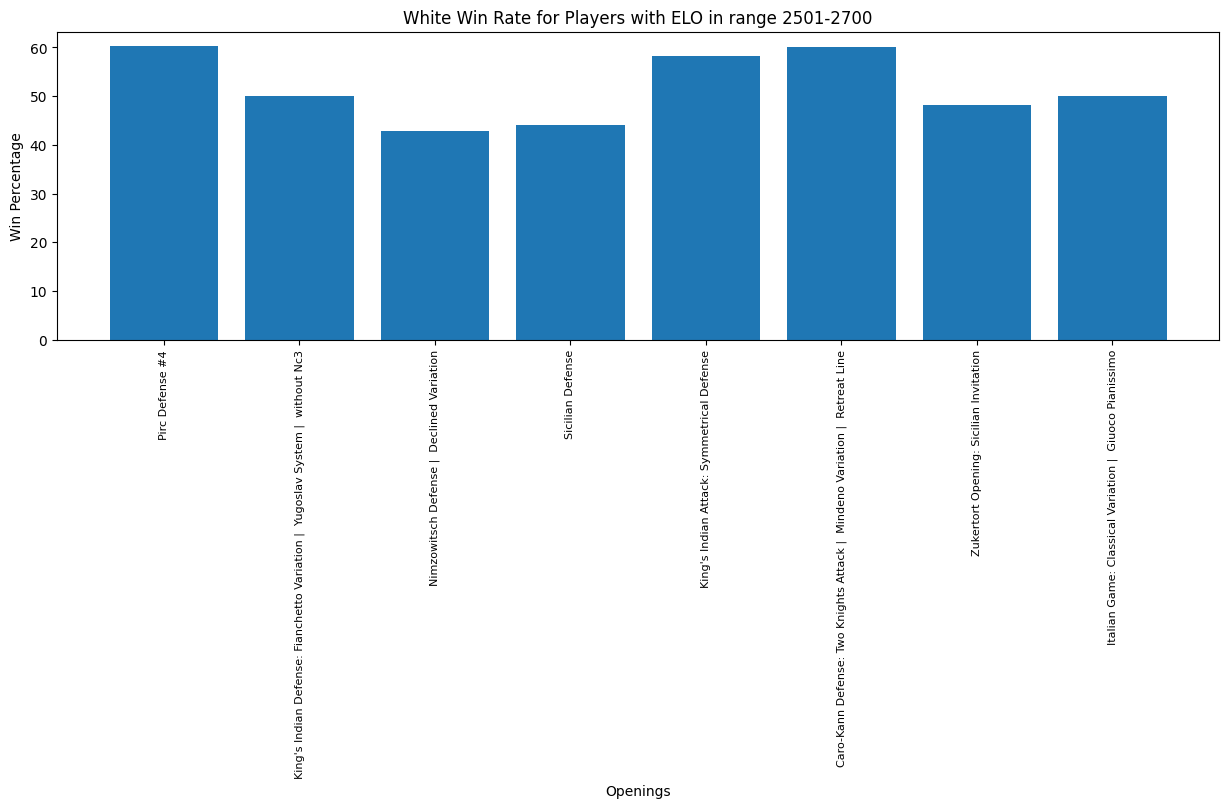

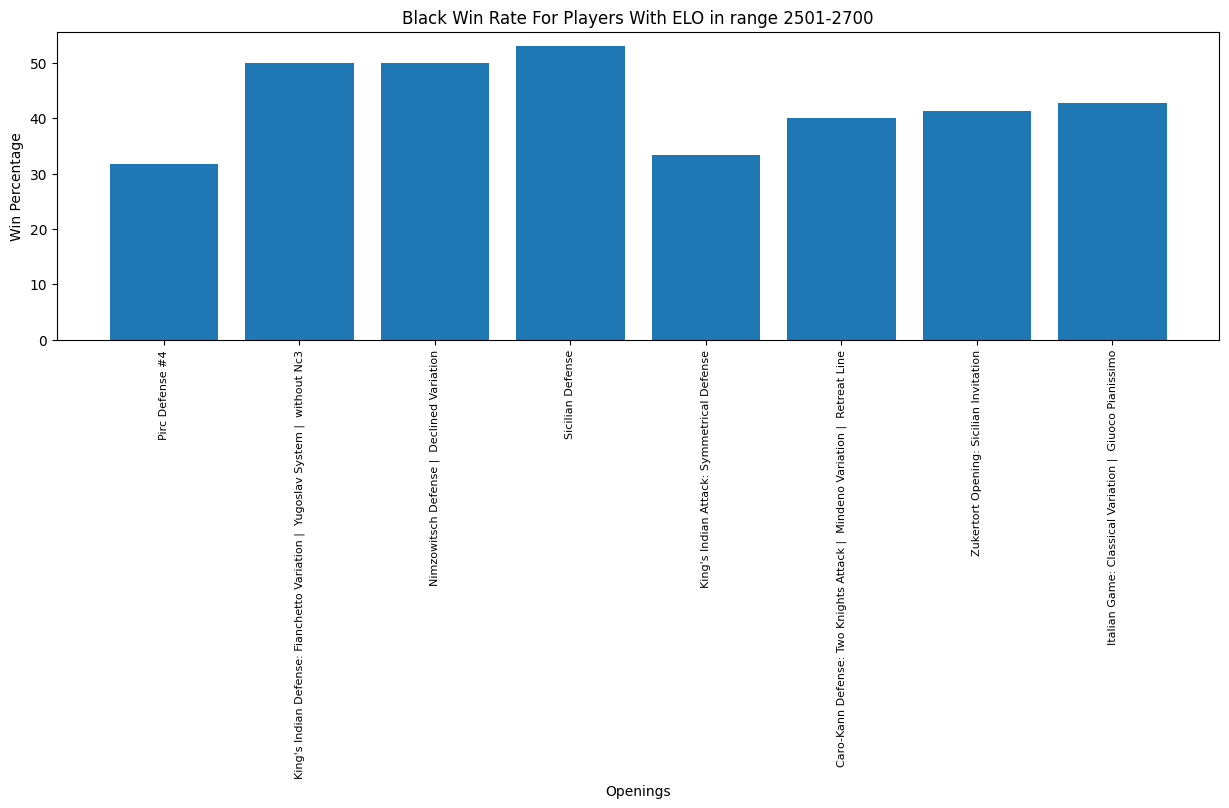

In [66]:
for rating_range, opening_freqs in elo_openings.items():
    ops = []
    white_win_percs = []
    black_win_percs = []
    
    # Get the openings and frequencies for this rating range
    if len(opening_freqs.keys()) > 100:
        # if there are more than 50 openings, only take ones from the top 50
        for opening, frequency in opening_freqs.items():
            top_openings = [tup[0] for tup in top_n_openings]
            if opening in top_openings:
                ops.append(opening)
                eco, (white, black, tie, freq) = openings[opening]
                white_win_percs.append(100 * (float(white) / float(freq)))
                black_win_percs.append(100 * (float(black) / float(freq)))
    else: 
        for opening, frequency in opening_freqs.items():
            ops.append(opening)
            eco, (white, black, tie, freq) = openings[opening]
            white_win_percs.append(100 * (float(white) / float(freq)))
            black_win_percs.append(100 * (float(black) / float(freq)))

    # Create Histogram for White
    fig_w, ax_w = plt.subplots(figsize=(15,4))
    ax_w.bar(ops, white_win_percs)
    ax_w.set_xticklabels(ops, rotation=90)
    plt.xticks(fontsize=8)
    ax_w.set_xlabel('Openings')
    ax_w.set_ylabel('Win Percentage')
    ax_w.set_title(f'White Win Rate for Players with ELO in range {rating_range}')
    plt.show()
    # Create Histogram for Black
    fig_b, ax_b = plt.subplots(figsize=(15,4))
    ax_b.bar(ops, black_win_percs)
    ax_b.set_xticklabels(ops, rotation=90)
    plt.xticks(fontsize=8)
    ax_b.set_xlabel('Openings')
    ax_b.set_ylabel('Win Percentage')
    ax_b.set_title(f'Black Win Rate For Players With ELO in range {rating_range}')
    plt.show()

In [ ]:
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
white_win_percentage = 100*(top_n_openings_df['White_Wins'].astype(float)/top_n_openings_df['Frequency'].astype(float))
ax_w.bar(top_n_openings_df['Opening_Name'], white_win_percentage)
# Set labels and title
ax_w.set_xticklabels(top_n_openings_df['Opening_Name'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# ax_w.tick_params(axis='x', which='major', pad=.5)
ax_w.set_xlabel('Openings')
ax_w.set_ylabel('Win Percentage')
ax_w.set_title('White Wins by Opening (Based on top 50 openings with the most games)')
plt.show()

In [104]:

# OLS for opening and white win percentage
top_n_openings_df['White_Win_Percentage'] = top_n_openings_df['White_Wins'] / top_n_openings_df['Frequency']
top_n_openings_df['Index'] = top_n_openings_df.index

results = statapi.ols(formula="White_Win_Percentage ~ Index", data=top_n_openings_df).fit()

# Print the summary statistics of the model
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     White_Win_Percentage   R-squared:                       0.032
Model:                              OLS   Adj. R-squared:                  0.012
Method:                   Least Squares   F-statistic:                     1.600
Date:                  Wed, 10 May 2023   Prob (F-statistic):              0.212
Time:                          21:59:06   Log-Likelihood:                 52.250
No. Observations:                    50   AIC:                            -100.5
Df Residuals:                        48   BIC:                            -96.68
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4819      0.024

In [185]:
# OLS for ECO and white win percentage
eco_df['White_Win_Percentage'] = eco_df['White_Wins'] / eco_df['Frequency']
eco_df['Index'] = eco_df.index

results = statapi.ols(formula="White_Win_Percentage ~ Index", data=eco_df).fit()

# Print the summary statistics of the model
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     White_Win_Percentage   R-squared:                       0.007
Model:                              OLS   Adj. R-squared:                 -0.014
Method:                   Least Squares   F-statistic:                    0.3183
Date:                  Wed, 10 May 2023   Prob (F-statistic):              0.575
Time:                          22:49:30   Log-Likelihood:                 66.869
No. Observations:                    50   AIC:                            -129.7
Df Residuals:                        48   BIC:                            -125.9
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4998      0.018

In [68]:
white_queen = []
black_queen = []
white_qwp = {}
black_qwp = {}
for i, row in rated_dataset.iterrows():
    moves = row[12].split()
    winner = row[6]
    black_count = 0
    white_count = 0     
    w_queen_found = False
    b_queen_found = False
    for j, move in enumerate(moves):
        # if index is even, it is white's move
        if j % 2 == 0: # even i
            if move[0] == 'Q':
                w_queen_found = True                
            if not w_queen_found and move[0] != 'Q':
                white_count += 1
        # if index is odd, it is black's move
        else: # odd is black
            if move[0] == 'Q':
                b_queen_found = True
            if not b_queen_found and move[0] != 'Q':
                black_count += 1    
        length = len(moves)
        if length % 2 == 0:
            if white_count == length // 2:
                 white_count = 0
            if black_count == length // 2:
                 black_count = 0
        else:
            if white_count == (length // 2) + 1:
                white_count = 0
            if black_count == length // 2:
                 black_count = 0   
    white_qwp.setdefault(white_count, [0, 0])  # white wins, total games
    white_qwp[white_count][1] += 1
    if winner == 'white':
        white_qwp[white_count][0] += 1
    black_qwp.setdefault(black_count, [0, 0])  # black wins, total games
    black_qwp[black_count][1] += 1
    if winner == 'black':
        black_qwp[black_count][0] += 1
    # white_queen.append(white_count)
    # black_queen.append(black_count)entire_dataset

In [ ]:
print(white_qwp.keys())
print(black_qwp.keys())

white_win_perc = [100*float(white_qwp[key][0]/white_qwp[key][1]) for key in white_qwp]
black_win_perc = [100*float(black_qwp[key][0]/black_qwp[key][1]) for key in black_qwp]

print(white_win_perc)
print(black_win_perc)

dict_keys([5, 24, 13, 12, 9, 4, 0, 2, 7, 6, 16, 14, 19, 10, 8, 11, 1, 22, 15, 21, 3, 20, 23, 26, 17, 18, 39, 25, 31, 43, 34, 29, 33, 28, 27, 30, 53, 46, 56, 32, 48, 58, 54, 35, 45, 60, 59, 44, 42, 57, 52, 70, 73, 49, 41, 50])
dict_keys([0, 13, 5, 10, 11, 1, 12, 9, 7, 18, 15, 2, 4, 8, 3, 17, 29, 19, 6, 16, 14, 23, 20, 28, 58, 21, 24, 22, 49, 31, 25, 30, 42, 39, 27, 26, 36, 60, 41, 34, 55, 47, 32, 38, 46, 52, 56, 45, 72, 43, 33, 57, 37, 65, 48, 77, 50])
[49.66814159292036, 50.0, 50.83102493074792, 48.44444444444444, 50.45289855072463, 51.05263157894737, 44.03567447045708, 46.666666666666664, 51.288888888888884, 50.811359026369175, 51.470588235294116, 48.67807153965785, 45.28301886792453, 50.58939096267191, 51.74693106704438, 51.96687370600414, 48.529411764705884, 44.73684210526316, 51.689189189189186, 49.673202614379086, 52.59259259259259, 56.25, 57.14285714285714, 57.14285714285714, 49.876543209876544, 48.45679012345679, 100.0, 53.06122448979592, 66.66666666666666, 100.0, 42.85714285714

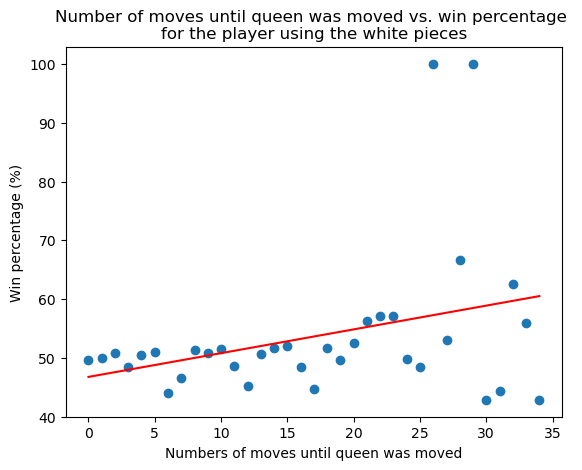

In [ ]:
# create scatter plot for white

white_xvals = list(white_qwp.keys())
white_xvals.sort()
w_first35 = white_xvals[0:35]
w_first35_2D = np.array(w_first35).reshape((-1, 1))  # reshape data to fit x axis
w_model = linreg().fit(w_first35_2D, white_win_perc[0:35])
w_preds = w_model.predict(w_first35_2D)
plt.scatter(w_first35, white_win_perc[0:35])
plt.plot(w_first35, w_preds, color='red')
plt.xlabel('Numbers of moves until queen was moved')
plt.ylabel('Win percentage (%)')
plt.title('Number of moves until queen was moved vs. win percentage \nfor the player using the white pieces')
plt.show()

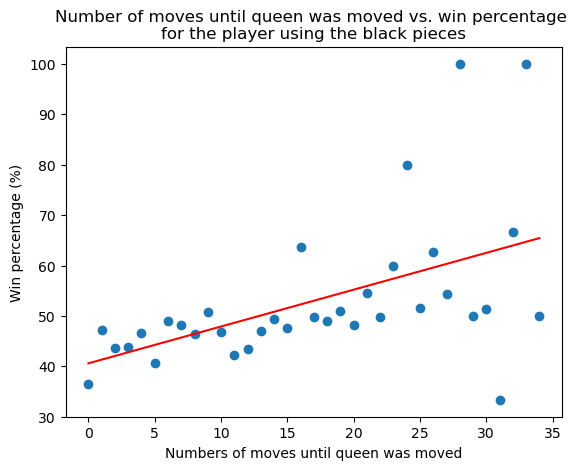

In [ ]:
# create scatter plot for black
black_xvals = list(black_qwp.keys())
black_xvals.sort()
b_first35 = black_xvals[0:35]
b_first35_2D = np.array(b_first35).reshape((-1, 1))  # reshape data to fit x axis
b_model = linreg().fit(b_first35_2D, black_win_perc[0:35])
b_preds = b_model.predict(b_first35_2D)
plt.scatter(b_first35, black_win_perc[0:35])
plt.plot(b_first35, b_preds, color='red')
plt.xlabel('Numbers of moves until queen was moved')
plt.ylabel('Win percentage (%)')
plt.title('Number of moves until queen was moved vs. win percentage \nfor the player using the black pieces')
plt.show()

[2.8977680745453753, 2.8254240638334025, 3.252246576789716, 0.4614636726946202, 2.0657153611832015, 2.261245971614322, -5.159913554667575, -2.9331237762496087, 1.2848960281810022, 0.40316374786967657, 0.6581905390030087, -2.5385285744248733, -6.3377836639498, -1.435613986994042, -0.6822763004131787, -0.8665360792450372, -4.708200438334899, -8.904972515569241, -2.356827849434822, -4.777016842036538, -2.261829281614645, 0.9913757080011507, 1.4800304330666805, 1.0758280152750643, -6.594688335497139, -8.418643839708508, 42.72036361904309, -4.622614308952606, 8.578625450126523, 41.50775636566825, -16.039303194980505, -14.856204025470532, 2.795149112293416, -4.109053305498193, -17.656112866146955]


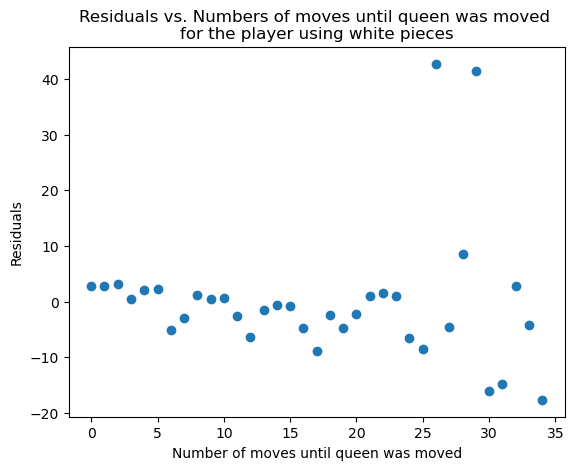

In [ ]:
# create new residuals column by subtracting predicted values from actual values
# data['residuals'] = data['lifeExp'] - model.predict()  
w_residuals = []
for i, move in enumerate(w_first35):
    residual = white_win_perc[i] - w_preds[i]
    w_residuals.append(residual)
print(w_residuals)
# residual data
# sb.violinplot(x=w_first35, y=w_residuals)
plt.scatter(w_first35, w_residuals)
plt.xlabel("Number of moves until queen was moved")
plt.ylabel('Residuals')
plt.title('Residuals vs. Numbers of moves until queen was moved \nfor the player using white pieces')
plt.show()


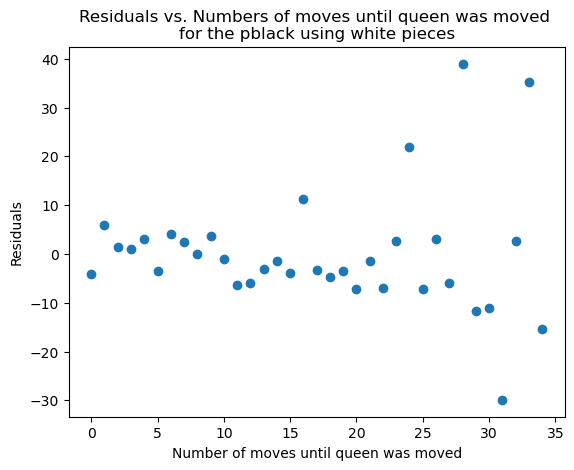

In [ ]:
b_residuals = []
for i, move in enumerate(b_first35):
    residual = black_win_perc[i] - b_preds[i]
    b_residuals.append(residual)

plt.scatter(b_first35, b_residuals)
plt.xlabel("Number of moves until queen was moved")
plt.ylabel('Residuals')
plt.title('Residuals vs. Numbers of moves until queen was moved \nfor the pblack using white pieces')
plt.show()

Null Hypothesis: when you move your queen has no significant effect on win percentage

Alternative Hypothesis: when you move your queen has a significant effect on win percentage

In [ ]:
white_queen_wp_df = pd.DataFrame(columns=['Num_Moves', 'Win_Percentage'])
for i, moves in enumerate(w_first35):
    white_queen_wp_df.loc[i] = [moves, white_win_perc[i]]
# display(white_queen_wp_df)

model2 = statapi.ols(formula="Num_Moves ~ Win_Percentage", data=white_queen_wp_df).fit()

# print results of Ordinary Least Squares model
print(model2.summary())
print(f'\np-values: \n{model2.pvalues}')

                            OLS Regression Results                            
Dep. Variable:              Num_Moves   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     3.981
Date:                Wed, 10 May 2023   Prob (F-statistic):             0.0543
Time:                        19:02:33   Log-Likelihood:                -128.61
No. Observations:                  35   AIC:                             261.2
Df Residuals:                      33   BIC:                             264.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.7136      7.350      0.

In [ ]:
print(model2.f_test(np.identity(len(model2.params))))

<F test: F=54.3803330045089, p=3.587651229588293e-11, df_denom=33, df_num=2>


In [ ]:
print(openings)

{'Nimzowitsch Defense: Kennedy Variation': ('B00', [1, 2, 0, 3]), "King's Pawn Game: Leonardis Variation": ('C20', [54, 53, 2, 109]), "Queen's Pawn Game: Zukertort Variation": ('D02', [47, 32, 5, 84]), 'Philidor Defense': ('C41', [68, 35, 6, 109]), 'Blackmar-Diemer Gambit: Pietrowsky Defense': ('D00', [2, 0, 0, 2]), 'Italian Game: Schilling-Kostic Gambit': ('C50', [11, 20, 3, 34]), 'Scandinavian Defense: Mieses-Kotroc Variation': ('B01', [129, 73, 5, 207]), "English Opening: King's English Variation |  Reversed Closed Sicilian": ('A25', [13, 4, 0, 17]), 'Sicilian Defense: Smith-Morra Gambit #2': ('B21', [45, 42, 5, 92]), "Queen's Pawn Game: Chigorin Variation": ('D01', [84, 91, 5, 180]), 'Scotch Game: Haxo Gambit': ('C45', [8, 1, 0, 9]), 'Slav Defense': ('D10', [13, 17, 3, 33]), "Queen's Gambit Refused: Marshall Defense": ('D06', [75, 28, 1, 104]), 'Sicilian Defense: Canal Attack |  Main Line': ('B52', [10, 15, 0, 25]), 'Sicilian Defense': ('B27', [125, 150, 8, 283]), 'Robatsch (Modern

In [170]:
ratings_and_openings = pd.DataFrame(columns=['White_ELO', 'Black_ELO', 'Opening_Name', 'Opening_Win_Rate_W', 'Opening_Win_Rate_B', 'Draw_Rate', 'White_Win', 'Black_Win'])
for i, row in rated_dataset.iterrows():
    white_elo = row['white_rating']
    black_elo = row['black_rating']
    opening_name = row['opening_name']

    winner = row['winner']
    white_win = 1 if winner == 'white' else 0
    black_win = 1 if winner == 'black' else 0
    white_wins = openings[opening_name][1][0]
    black_wins = openings[opening_name][1][1]
    game_freq = openings[opening_name][1][3]
    opening_wrate_W = white_wins / game_freq
    opening_wrate_B = black_wins / game_freq
    draw_rate = 1 - opening_wrate_B - opening_wrate_W
    if game_freq >= 25:
        ratings_and_openings.loc[i] = [white_elo, black_elo, opening_name, opening_wrate_W, opening_wrate_B, draw_rate, white_win, black_win]
# print(ratings_and_openings.shape[0])
display(ratings_and_openings.head())

White_ELO  Black_ELO                                   Opening_Name  \
2       1496       1500          King's Pawn Game: Leonardis Variation   
3       1439       1454         Queen's Pawn Game: Zukertort Variation   
4       1523       1469                               Philidor Defense   
8       1439       1392          Italian Game: Schilling-Kostic Gambit   
9       1381       1209  Scandinavian Defense: Mieses-Kotroc Variation   

   Opening_Win_Rate_W  Opening_Win_Rate_B  Draw_Rate  White_Win  Black_Win  
2            0.495413            0.486239   0.018349          1          0  
3            0.559524            0.380952   0.059524          1          0  
4            0.623853            0.321101   0.055046          1          0  
8            0.323529            0.588235   0.088235          0          1  
9            0.623188            0.352657   0.024155          1          0

In [172]:
ratings_and_eco = pd.DataFrame(columns=['White_ELO', 'Black_ELO', 'Opening_ECO', 'ECO_Win_Rate_W', 'ECO_Win_Rate_B', 'Draw_Rate', 'White_Win', 'Black_Win'])
for i, row in rated_dataset.iterrows():
    white_elo = row['white_rating']
    black_elo = row['black_rating']
    opening_eco = row['opening_eco']

    winner = row['winner']
    white_win = 1 if winner == 'white' else 0
    black_win = 1 if winner == 'black' else 0
    white_wins = eco_win_pct[opening_eco][0]
    black_wins = eco_win_pct[opening_eco][1]
    game_freq = eco_win_pct[opening_eco][3]
    opening_wrate_W = white_wins / game_freq
    opening_wrate_B = black_wins / game_freq
    draw_rate = 1 - opening_wrate_B - opening_wrate_W
    if game_freq >= 25:
        ratings_and_eco.loc[i] = [white_elo, black_elo, opening_name, opening_wrate_W, opening_wrate_B, draw_rate, white_win, black_win]
# print(ratings_and_openings.shape[0])
display(ratings_and_eco.head())

White_ELO  Black_ELO                      Opening_ECO  ECO_Win_Rate_W  \
1       1322       1261  Queen's Pawn Game: Mason Attack        0.590909   
2       1496       1500  Queen's Pawn Game: Mason Attack        0.468284   
3       1439       1454  Queen's Pawn Game: Mason Attack        0.498534   
4       1523       1469  Queen's Pawn Game: Mason Attack        0.573712   
6       1520       1423  Queen's Pawn Game: Mason Attack        0.457286   

   ECO_Win_Rate_B  Draw_Rate  White_Win  Black_Win  
1        0.370130   0.038961          0          1  
2        0.503731   0.027985          1          0  
3        0.457478   0.043988          1          0  
4        0.390764   0.035524          1          0  
6        0.490787   0.051926          1          0

In [92]:
ratings_and_openings_top50 = ratings_and_openings.copy()
for i, row in ratings_and_openings_top50.iterrows():
    top_openings = [tup[0] for tup in top_n_openings]
    if row['Opening_Name'] not in top_openings:
        ratings_and_openings_top50.drop(i, inplace=True)
display(ratings_and_openings_top50)

White_ELO  Black_ELO                                   Opening_Name  \
2           1496       1500          King's Pawn Game: Leonardis Variation   
3           1439       1454         Queen's Pawn Game: Zukertort Variation   
4           1523       1469                               Philidor Defense   
9           1381       1209  Scandinavian Defense: Mieses-Kotroc Variation   
24          1113       1423        Sicilian Defense: Smith-Morra Gambit #2   
...          ...        ...                                            ...   
20050       1243       1142      English Opening: King's English Variation   
20051       1237       1231               French Defense: Knight Variation   
20054       1233       1196                                   Queen's Pawn   
20055       1219       1286                Queen's Pawn Game: Mason Attack   
20057       1235       1339                Queen's Pawn Game: Mason Attack   

       Opening_Win_Rate_W  Opening_Win_Rate_B  Draw_Rate  White_Win  Black_Win  
2                0.495413            0.486239   0.018349          1          0  
3                0.559524            0.380952   0.059524          1          0  
4                0.623853            0.321101   0.055046          1          0  
9                0.623188            0.352657   0.024155          1          0  
24               0.489130            0.456522   0.054348          0          1  
...                   ...                 ...        ...        ...        ...  
20050            0.551282            0.410256   0.038462          1          0  
20051            0.506550            0.436681   0.056769          0          1  
20054            0.632075            0.320755   0.047170          0          1  
20055            0.491979            0.459893   0.048128          1          0  
20057            0.491979            0.459893   0.048128          0          1  

[6334 rows x 8 columns]

In [93]:
ratings_and_openings_top50['Index'] = 0
arr = []
for i, row in ratings_and_openings_top50.iterrows():
    curr_row = top_n_openings_df[top_n_openings_df['Opening_Name'] == row['Opening_Name']]
    arr.append(curr_row.index.item())
    #ratings_and_openings_top50.at[i, 'Index'] = curr_row.index
ratings_and_openings_top50['Index'] = arr
display(ratings_and_openings_top50.head())

White_ELO  Black_ELO                                   Opening_Name  \
2        1496       1500          King's Pawn Game: Leonardis Variation   
3        1439       1454         Queen's Pawn Game: Zukertort Variation   
4        1523       1469                               Philidor Defense   
9        1381       1209  Scandinavian Defense: Mieses-Kotroc Variation   
24       1113       1423        Sicilian Defense: Smith-Morra Gambit #2   

    Opening_Win_Rate_W  Opening_Win_Rate_B  Draw_Rate  White_Win  Black_Win  \
2             0.495413            0.486239   0.018349          1          0   
3             0.559524            0.380952   0.059524          1          0   
4             0.623853            0.321101   0.055046          1          0   
9             0.623188            0.352657   0.024155          1          0   
24            0.489130            0.456522   0.054348          0          1   

    Index  
2      22  
3      38  
4      23  
9       5  
24     32

In [100]:
results = statapi.ols(formula="Opening_Win_Rate_W ~ White_ELO + Index", data=ratings_and_openings_top50).fit()
print(results.pvalues)

Intercept     0.000000e+00
White_ELO     7.587384e-14
Index        1.315902e-127
dtype: float64


In [154]:
white_elo_diff_wrate = {}
black_elo_diff_wrate = {}
for i, row in ratings_and_openings.iterrows():
    w_elo_diff = row['White_ELO'] - row['Black_ELO']
    white_won = row['White_Win']
    black_won = row['Black_Win']
    b_elo_diff = -1 * w_elo_diff
    white_elo_diff_wrate.setdefault(w_elo_diff, [0, 0])
    black_elo_diff_wrate.setdefault(b_elo_diff, [0, 0])
    white_elo_diff_wrate[w_elo_diff][0] += 1 if white_won else 0
    black_elo_diff_wrate[b_elo_diff][0] += 1 if black_won else 0
    white_elo_diff_wrate[w_elo_diff][1] += 1
    black_elo_diff_wrate[b_elo_diff][1] += 1

white_sorted_keys = sorted(list(white_elo_diff_wrate.keys()))
black_sorted_keys = sorted(list(black_elo_diff_wrate.keys()))
print(white_sorted_keys)
print(black_sorted_keys)

[-1155, -1086, -1077, -970, -965, -959, -958, -943, -922, -921, -919, -878, -867, -866, -860, -859, -856, -852, -842, -841, -839, -838, -836, -834, -830, -827, -822, -814, -805, -799, -798, -787, -785, -783, -775, -771, -764, -754, -750, -743, -736, -733, -730, -729, -727, -726, -725, -721, -720, -717, -714, -712, -711, -710, -705, -704, -703, -702, -701, -697, -695, -690, -689, -688, -686, -685, -676, -673, -671, -670, -669, -668, -665, -664, -663, -660, -659, -658, -657, -655, -650, -642, -637, -634, -633, -632, -630, -625, -624, -623, -622, -621, -618, -617, -615, -613, -612, -611, -610, -608, -607, -605, -604, -602, -600, -599, -598, -595, -590, -588, -586, -583, -581, -578, -575, -573, -570, -567, -566, -564, -562, -560, -559, -555, -554, -553, -550, -548, -546, -544, -543, -542, -540, -538, -537, -536, -534, -533, -532, -529, -528, -526, -524, -523, -522, -521, -520, -519, -518, -515, -514, -513, -512, -511, -510, -509, -507, -505, -504, -503, -502, -500, -499, -497, -496, -494, 

In [155]:
white_bins = pd.cut(white_sorted_keys, bins=range(-1200, 1100, 100))
black_bins = pd.cut(black_sorted_keys, bins=range(-1000, 1300, 100))


In [156]:
white_wrate = [100 * (white_elo_diff_wrate[key][0] / white_elo_diff_wrate[key][1]) for key in white_sorted_keys]
black_wrate = [100 * (black_elo_diff_wrate[key][0] / black_elo_diff_wrate[key][1]) for key in black_sorted_keys]

In [157]:
new_white_df = pd.DataFrame({'White Rating Diff': white_sorted_keys, 'White Win Rate': white_wrate})
new_black_df = pd.DataFrame({'Black Rating Diff': black_sorted_keys, 'Black Win Rate': black_wrate})
white_result = new_white_df.groupby(white_bins)['White Win Rate'].mean()
black_result = new_black_df.groupby(black_bins)['Black Win Rate'].mean()
# display(new_white_df)
# display(new_black_df.head())
white_result = white_result.to_frame()
black_result = black_result.to_frame()



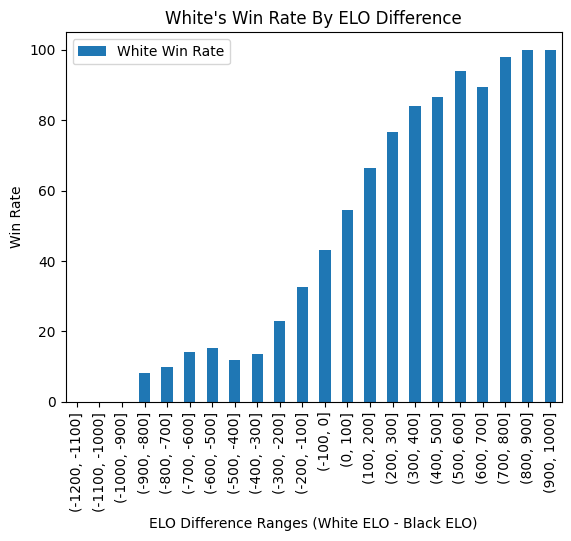

In [158]:

white_result.plot.bar()
plt.title('White\'s Win Rate By ELO Difference')
plt.xlabel('ELO Difference Ranges (White ELO - Black ELO)')
plt.ylabel('Win Rate')
plt.show()

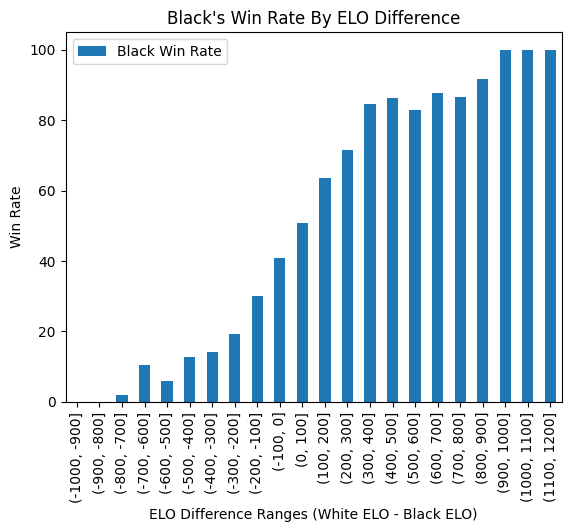

In [159]:
black_result.plot.bar()
plt.title('Black\'s Win Rate By ELO Difference')
plt.xlabel('ELO Difference Ranges (White ELO - Black ELO)')
plt.ylabel('Win Rate')
plt.show()

Null Hypothesis: ELO difference does not have a statistically significant effect on win rate for the White player

Alternative Hypothesis: ELO difference does have a statistically significant effect on win rate for the White player

In [160]:
bin_edges = white_result.index.categories
midpoints = bin_edges.mid

# Define the predictor variable and response variable
X = midpoints
y = white_result['White Win Rate']

# Add a constant term to the predictor variable
X = statsmodels.api.add_constant(X)

# Fit the OLS model
ols_model = statsmodels.api.OLS(y, X).fit()

# Print the model summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         White Win Rate   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     337.6
Date:                Wed, 10 May 2023   Prob (F-statistic):           5.42e-14
Time:                        22:29:21   Log-Likelihood:                -79.320
No. Observations:                  22   AIC:                             162.6
Df Residuals:                      20   BIC:                             164.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.1969      2.016     25.897      0.0

In [161]:
bin_edges = black_result.index.categories
midpoints = bin_edges.mid

# Define the predictor variable and response variable
X = midpoints
y = black_result['Black Win Rate']

# Add a constant term to the predictor variable
X = statsmodels.api.add_constant(X)

# Fit the OLS model
ols_model = statsmodels.api.OLS(y, X).fit()

# Print the model summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Black Win Rate   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     375.9
Date:                Wed, 10 May 2023   Prob (F-statistic):           1.95e-14
Time:                        22:29:24   Log-Likelihood:                -78.162
No. Observations:                  22   AIC:                             160.3
Df Residuals:                      20   BIC:                             162.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.0964      1.912     24.105      0.0

In [163]:
X_w = pd.DataFrame({'Rating Diff': ratings_and_openings['White_ELO'] - ratings_and_openings['Black_ELO'], 'Win Rate': ratings_and_openings['Opening_Win_Rate_W']})
y_w = ratings_and_openings['White_Win']
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.2, random_state=42)

In [164]:
tree_model_w = sklearn.tree.DecisionTreeClassifier(random_state=42)

# # Train the model
tree_model_w.fit(X_train_w, y_train_w)

# # Predict the target variable for the test set
tree_y_pred_w = tree_model_w.predict(X_test_w)
# for p in tree_y_pred:
#     print(p)
tree_accuracy_w = accuracy_score(y_test_w, tree_y_pred_w)
print('Decision Tree Model Accuracy (W):', tree_accuracy_w)

Decision Tree Model Accuracy (W): 0.5848780487804878


In [165]:
log_model_w = LogisticRegression(random_state=42)

# Train the model
log_model_w.fit(X_train_w, y_train_w)

# Predict the target variable for the test set
log_y_pred_w = log_model_w.predict(X_test_w)

# Evaluate the model
log_accuracy_w = accuracy_score(y_test_w, log_y_pred_w)
print('Logistic Regression Accuracy:', log_accuracy_w)

Logistic Regression Accuracy: 0.6590243902439025


In [167]:
X_b = pd.DataFrame({'Rating Diff': ratings_and_openings['Black_ELO'] - ratings_and_openings['White_ELO'], 'Win Rate': ratings_and_openings['Opening_Win_Rate_B']})
y_b = ratings_and_openings['Black_Win']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

In [168]:
tree_model_b = sklearn.tree.DecisionTreeClassifier(random_state=42)

# # Train the model
tree_model_b.fit(X_train_b, y_train_b)

# # Predict the target variable for the test set
tree_y_pred_b = tree_model_b.predict(X_test_b)
# for p in tree_y_pred:
#     print(p)
tree_accuracy_b = accuracy_score(y_test_b, tree_y_pred_b)
print('Decision Tree Model Accuracy (B):', tree_accuracy_b)

Decision Tree Model Accuracy (B): 0.5814634146341463


In [169]:
log_model_b = LogisticRegression(random_state=42)

# Train the model
log_model_b.fit(X_train_b, y_train_b)

# Predict the target variable for the test set
log_y_pred_b = log_model_b.predict(X_test_b)

# Evaluate the model
log_accuracy_b = accuracy_score(y_test_b, log_y_pred_b)
print('Logistic Regression Accuracy:', log_accuracy_b)

Logistic Regression Accuracy: 0.6536585365853659


In [176]:
# Attempt to make model better using ECO instead
X_w_eco = pd.DataFrame({'Rating Diff': ratings_and_eco['White_ELO'] - ratings_and_eco['Black_ELO'], 'Win Rate': ratings_and_eco['ECO_Win_Rate_W']})
y_w_eco = ratings_and_eco['White_Win']
X_train_w_eco, X_test_w_eco, y_train_w_eco, y_test_w_eco = train_test_split(X_w_eco, y_w, test_size=0.2, random_state=42)

In [177]:
tree_model_w = sklearn.tree.DecisionTreeClassifier(random_state=42)

# # Train the model
tree_model_w.fit(X_train_w_eco, y_train_w_eco)

# # Predict the target variable for the test set
tree_y_pred_w = tree_model_w.predict(X_test_w_eco)
# for p in tree_y_pred:
#     print(p)
tree_accuracy_w = accuracy_score(y_test_w_eco, tree_y_pred_w)
print('Decision Tree Model Accuracy (W):', tree_accuracy_w)

Decision Tree Model Accuracy (W): 0.5909405255878285


In [178]:
log_model_w = LogisticRegression(random_state=42)

# Train the model
log_model_w.fit(X_train_w_eco, y_train_w_eco)

# Predict the target variable for the test set
log_y_pred_w = log_model_w.predict(X_test_w_eco)

# Evaluate the model
log_accuracy_w = accuracy_score(y_test_w_eco, log_y_pred_w)
print('Logistic Regression Accuracy:', log_accuracy_w)

Logistic Regression Accuracy: 0.6542185338865837


In [181]:
X_b_eco = pd.DataFrame({'Rating Diff': ratings_and_eco['Black_ELO'] - ratings_and_eco['White_ELO'], 'Win Rate': ratings_and_eco['ECO_Win_Rate_B']})
y_b_eco = ratings_and_eco['Black_Win']
X_train_b_eco, X_test_b_eco, y_train_b_eco, y_test_b_eco = train_test_split(X_b_eco, y_b_eco, test_size=0.2, random_state=42)

In [182]:
tree_model_b = sklearn.tree.DecisionTreeClassifier(random_state=42)

# # Train the model
tree_model_b.fit(X_train_b_eco, y_train_b_eco)

# # Predict the target variable for the test set
tree_y_pred_b = tree_model_b.predict(X_test_b_eco)
# for p in tree_y_pred:
#     print(p)
tree_accuracy_b = accuracy_score(y_test_b_eco, tree_y_pred_b)
print('Decision Tree Model Accuracy (B):', tree_accuracy_b)

Decision Tree Model Accuracy (B): 0.6103042876901799


In [184]:
log_model_b = LogisticRegression(random_state=42)

# Train the model
log_model_b.fit(X_train_b_eco, y_train_b_eco)

# Predict the target variable for the test set
log_y_pred_b = log_model_b.predict(X_test_b_eco)

# Evaluate the model
log_accuracy_b = accuracy_score(y_test_b_eco, log_y_pred_b)
print('Logistic Regression Accuracy:', log_accuracy_b)

Logistic Regression Accuracy: 0.6562932226832642
